In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# Fitting transit times

Fitting for or marginalizing over the transit times or transit timing variations (TTVs) can be useful for several reasons, and it is a compelling use case for `exoplanet` becuase the number of parameters in the model increases significantly because there will be a new parameter for each transit.
The performance of the NUTS sampler used by `exoplanet` scales well with the number of parameters, so a TTV model should be substantially faster to run to convergence with `exoplanet` than with other tools.
There are a few definitions and subtleties that should be considered before jumping in.

In this tutorial, we will be using a "descriptive" model :class:`orbits.TTVOrbit` to fit the light curve where the underlying motion is still Keplerian, but the time coordinate is warped to make `t0` a function of time.
All of the other orbital elements besides `t0` are shared across all orbits, but the `t0` for each transit will be a parameter.
This means that other variations (like transit duration variations) are not currently supported, but it would be possible to include more general effects.
`exoplanet` also supports photodynamics modeling using the :class:`orbits.ReboundOrbit` for more detailed analysis, but that is a topic for a future tutorial.

It is also important to note that "transit time" within `exoplanet` (and most other transit fitting software) is defined as the time of conjunction (called `t0` in the code): the time when the true anomaly is $\pi/2 - \omega$.
Section 18 of [the EXOFASTv2 paper](https://arxiv.org/abs/1907.09480) includes an excellent discussion of some of the commonly used definitions of "transit time" in the literature.

Finally, there is a subtlety in the definition of the "period" of an orbit with TTVs.
Two possible definitions are: (1) the average time between transits, or (2) the slope of a least squares fit to the transit times as a function of transit number.
In `exoplanet`, we use the latter definition and call this parameter the `ttv_period` to distinguish it from the `period` of the underlying Keplerian motion which sets the shape and duration of the transit.
By default, these two periods are constrained to be equal, but it can be useful to fit for both parameters since the shape of the transit might not be perfectly described by the same period.
That being said, if you fit for both periods, make sure that you constrain `ttv_period` and `period` to be similar or things can get a bit ugly.

To get started, let's generate some simulated transit times.
We'll use the :func:`orbits.ttv.compute_expected_transit_times` function to get the expected transit times for a linear ephemeris within some observation baseline:

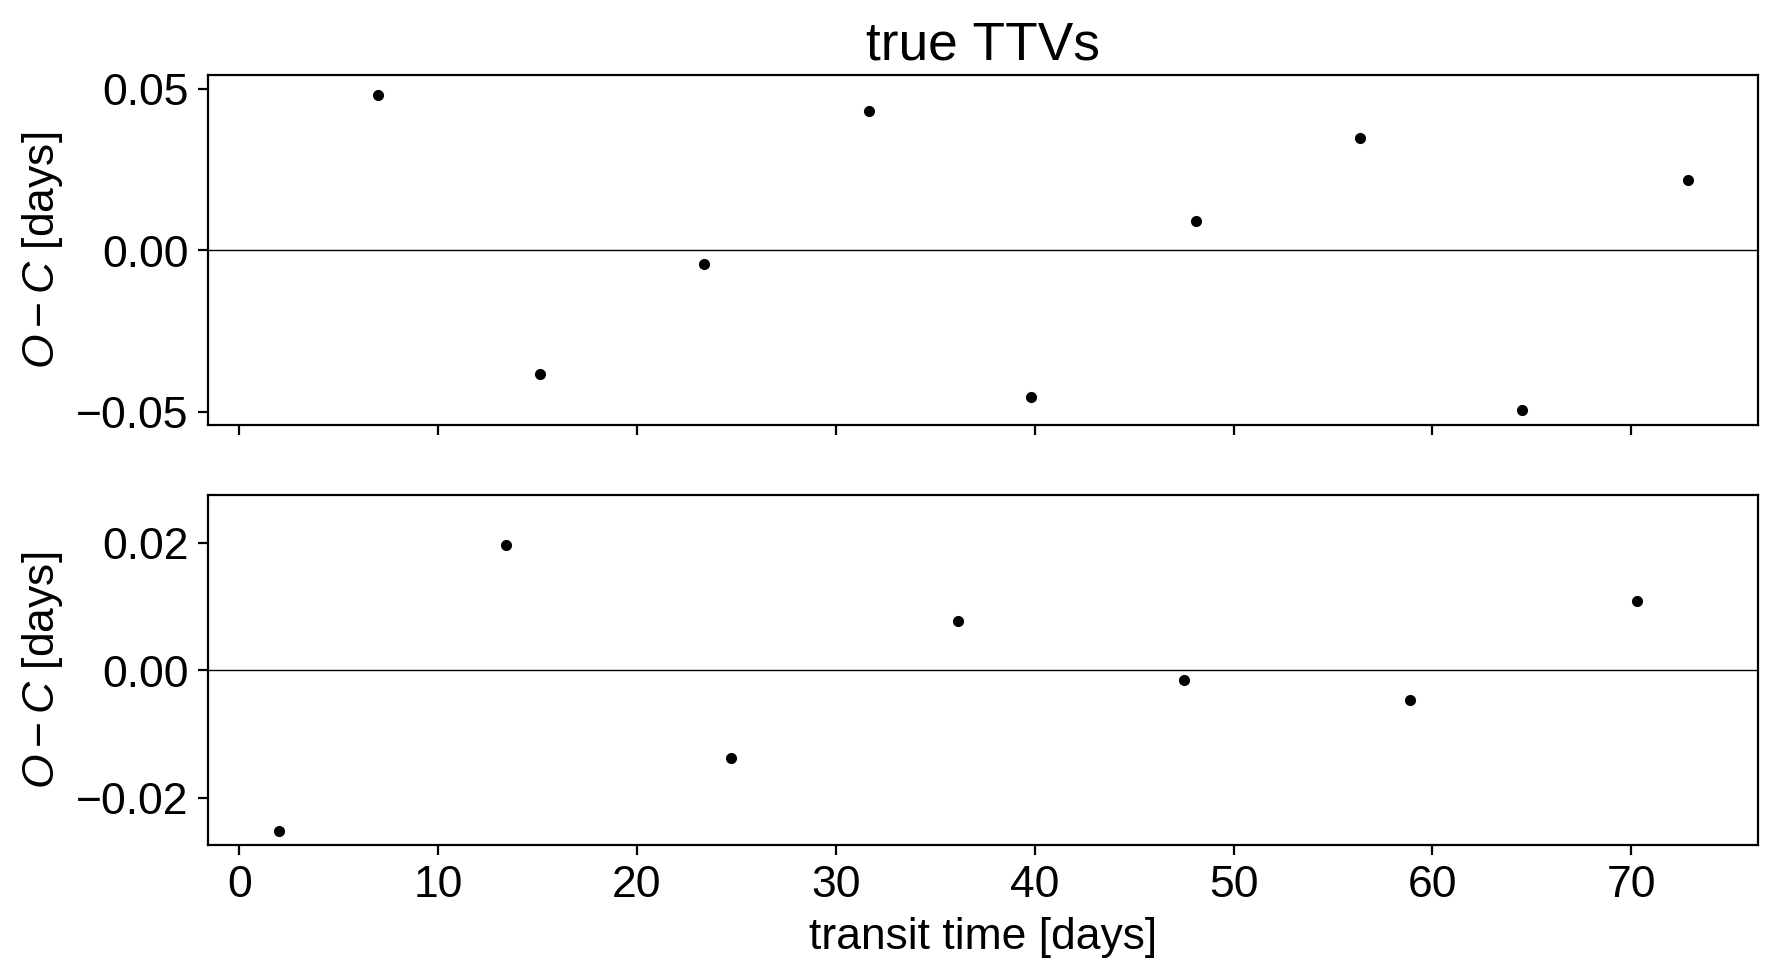

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import exoplanet as xo

np.random.seed(3948)
true_periods = np.random.uniform(8, 12, 2)
true_t0s = true_periods * np.random.rand(2)
t = np.arange(0, 80, 0.01)
texp = 0.01
yerr = 5e-4

# Compute the transit times for a linear ephemeris
true_transit_times = xo.orbits.ttv.compute_expected_transit_times(
    t.min(), t.max(), true_periods, true_t0s
)

# Simulate transit timing variations using a simple model
true_ttvs = [
    (0.05 - (i % 2) * 0.1) * np.sin(2 * np.pi * tt / 23.7)
    for i, tt in enumerate(true_transit_times)
]
true_transit_times = [tt + v for tt, v in zip(true_transit_times, true_ttvs)]

# Plot the true TTV model
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
ax1.plot(true_transit_times[0], true_ttvs[0], ".k")
ax1.axhline(0, color="k", lw=0.5)
ax1.set_ylim(np.max(np.abs(ax1.get_ylim())) * np.array([-1, 1]))
ax1.set_ylabel("$O-C$ [days]")

ax2.plot(true_transit_times[1], true_ttvs[1], ".k")
ax2.axhline(0, color="k", lw=0.5)
ax2.set_ylim(np.max(np.abs(ax2.get_ylim())) * np.array([-1, 1]))
ax2.set_ylabel("$O-C$ [days]")

ax2.set_xlabel("transit time [days]")
ax1.set_title("true TTVs");

Now, like in the :ref:`transit` tutorial, we'll set up the the model using `PyMC3` and `exoplanet`, and then simulate a data set from that model.

In [4]:
import pymc3 as pm
import theano.tensor as tt

np.random.seed(9485023)

with pm.Model() as model:

    # This part of the model is similar to the model in the `transit` tutorial
    mean = pm.Normal("mean", mu=0.0, sd=1.0)
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.3, 0.2]))
    logr = pm.Uniform(
        "logr",
        lower=np.log(0.01),
        upper=np.log(0.1),
        shape=2,
        testval=np.log([0.04, 0.06]),
    )
    r = pm.Deterministic("r", tt.exp(logr))
    b = xo.distributions.ImpactParameter(
        "b", ror=r, shape=2, testval=0.5 * np.random.rand(2)
    )

    # Now we have a parameter for each transit time for each planet:
    transit_times = []
    for i in range(2):
        transit_times.append(
            pm.Normal(
                "tts_{0}".format(i),
                mu=true_transit_times[i],
                sd=1.0,
                shape=len(true_transit_times[i]),
            )
        )

    # Set up an orbit for the planets
    orbit = xo.orbits.TTVOrbit(b=b, transit_times=transit_times)

    # It will be useful later to track some parameters of the orbit
    pm.Deterministic("t0", orbit.t0)
    pm.Deterministic("period", orbit.period)
    for i in range(2):
        pm.Deterministic("ttvs_{0}".format(i), orbit.ttvs[i])

    # The rest of this block follows the transit fitting tutorial
    light_curves = xo.LimbDarkLightCurve(u).get_light_curve(
        orbit=orbit, r=r, t=t, texp=texp
    )
    light_curve = pm.math.sum(light_curves, axis=-1) + mean
    pm.Deterministic("light_curves", light_curves)
    y = xo.eval_in_model(light_curve)
    y += yerr * np.random.randn(len(y))
    pm.Normal("obs", mu=light_curve, sd=yerr, observed=y)

    map_soln = model.test_point
    map_soln = xo.optimize(start=map_soln, vars=transit_times)
    map_soln = xo.optimize(start=map_soln, vars=[r, b])
    map_soln = xo.optimize(start=map_soln, vars=transit_times)
    map_soln = xo.optimize(start=map_soln)

optimizing logp for variables: [tts_1, tts_0]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=4.945488e+04]

1it [00:00, 80.45it/s, logp=4.945488e+04]

2it [00:00, 117.16it/s, logp=4.945488e+04]

3it [00:00, 139.26it/s, logp=4.317367e+04]

4it [00:00, 157.14it/s, logp=4.919676e+04]

5it [00:00, 176.32it/s, logp=4.945996e+04]

6it [00:00, 190.77it/s, logp=4.944404e+04]

7it [00:00, 193.54it/s, logp=4.946088e+04]

8it [00:00, 193.45it/s, logp=4.946008e+04]

9it [00:00, 194.99it/s, logp=4.946120e+04]

10it [00:00, 199.45it/s, logp=4.945897e+04]

11it [00:00, 204.08it/s, logp=4.946124e+04]

12it [00:00, 209.11it/s, logp=4.946111e+04]

13it [00:00, 215.61it/s, logp=4.946124e+04]

14it [00:00, 221.01it/s, logp=4.946122e+04]

15it [00:00, 227.11it/s, logp=4.946124e+04]

16it [00:00, 229.54it/s, logp=4.946124e+04]

17it [00:00, 232.16it/s, logp=4.946124e+04]

18it [00:00, 234.71it/s, logp=4.946124e+04]

19it [00:00, 239.10it/s, logp=4.946124e+04]

20it [00:00, 242.63it/s, logp=4.946124e+04]

21it [00:00, 245.06it/s, logp=4.946124e+04]

22it [00:00, 244.12it/s, logp=4.946124e+04]

23it [00:00, 243.73it/s, logp=4.946124e+04]

24it [00:00, 244.24it/s, logp=4.946124e+04]

25it [00:00, 245.40it/s, logp=4.946124e+04]

26it [00:00, 253.96it/s, logp=4.946124e+04]

26it [00:00, 253.96it/s, logp=4.946124e+04]

27it [00:00, 253.96it/s, logp=4.946124e+04]

28it [00:00, 253.96it/s, logp=4.946124e+04]

29it [00:00, 253.96it/s, logp=4.946124e+04]

30it [00:00, 253.96it/s, logp=4.946124e+04]

31it [00:00, 253.96it/s, logp=4.946124e+04]

32it [00:00, 253.96it/s, logp=4.946125e+04]

33it [00:00, 253.96it/s, logp=4.946125e+04]

34it [00:00, 253.96it/s, logp=4.946126e+04]

35it [00:00, 253.96it/s, logp=4.946113e+04]

36it [00:00, 253.96it/s, logp=4.946126e+04]

37it [00:00, 253.96it/s, logp=4.946071e+04]

38it [00:00, 253.96it/s, logp=4.946126e+04]

39it [00:00, 253.96it/s, logp=4.946126e+04]

40it [00:00, 253.96it/s, logp=4.946126e+04]

41it [00:00, 253.96it/s, logp=4.946126e+04]

42it [00:00, 253.96it/s, logp=4.946126e+04]

43it [00:00, 253.96it/s, logp=4.946126e+04]

44it [00:00, 253.96it/s, logp=4.946127e+04]

45it [00:00, 253.96it/s, logp=4.946128e+04]

46it [00:00, 253.96it/s, logp=4.946128e+04]

47it [00:00, 253.96it/s, logp=4.946128e+04]

48it [00:00, 253.96it/s, logp=4.946128e+04]

49it [00:00, 253.96it/s, logp=4.946128e+04]

50it [00:00, 253.96it/s, logp=4.946128e+04]

51it [00:00, 253.96it/s, logp=4.946128e+04]

52it [00:00, 253.96it/s, logp=4.946128e+04]

53it [00:00, 253.96it/s, logp=4.946128e+04]

54it [00:00, 253.96it/s, logp=4.946128e+04]

55it [00:00, 253.96it/s, logp=4.946128e+04]

56it [00:00, 253.96it/s, logp=4.946128e+04]

57it [00:00, 253.96it/s, logp=4.946128e+04]

58it [00:00, 253.96it/s, logp=4.946128e+04]

59it [00:00, 253.96it/s, logp=4.946128e+04]

60it [00:00, 253.96it/s, logp=4.946128e+04]

61it [00:00, 253.96it/s, logp=4.946128e+04]

62it [00:00, 253.96it/s, logp=4.946128e+04]

63it [00:00, 253.96it/s, logp=4.946128e+04]

64it [00:00, 281.65it/s, logp=4.946128e+04]

64it [00:00, 281.65it/s, logp=4.946128e+04]

65it [00:00, 281.65it/s, logp=4.946128e+04]

66it [00:00, 281.65it/s, logp=4.946128e+04]

67it [00:00, 281.65it/s, logp=4.946128e+04]

68it [00:00, 281.65it/s, logp=4.946128e+04]

69it [00:00, 281.65it/s, logp=4.946128e+04]

70it [00:00, 281.65it/s, logp=4.946128e+04]

71it [00:00, 281.65it/s, logp=4.946128e+04]

72it [00:00, 281.65it/s, logp=4.946128e+04]

73it [00:00, 281.65it/s, logp=4.946128e+04]

74it [00:00, 281.65it/s, logp=4.946128e+04]

75it [00:00, 281.65it/s, logp=4.946128e+04]

76it [00:00, 281.65it/s, logp=4.946128e+04]

77it [00:00, 281.65it/s, logp=4.946128e+04]

78it [00:00, 281.65it/s, logp=4.946128e+04]

79it [00:00, 281.65it/s, logp=4.946128e+04]

80it [00:00, 281.65it/s, logp=4.946128e+04]

81it [00:00, 281.65it/s, logp=4.946128e+04]

82it [00:00, 281.65it/s, logp=4.946128e+04]

83it [00:00, 281.65it/s, logp=4.946128e+04]

84it [00:00, 281.65it/s, logp=4.946128e+04]

85it [00:00, 281.65it/s, logp=4.946128e+04]

86it [00:00, 281.65it/s, logp=4.946128e+04]

87it [00:00, 281.65it/s, logp=4.946128e+04]

88it [00:00, 281.65it/s, logp=4.946128e+04]

89it [00:00, 281.65it/s, logp=4.946128e+04]

90it [00:00, 281.65it/s, logp=4.946128e+04]

91it [00:00, 281.65it/s, logp=4.946128e+04]

92it [00:00, 281.65it/s, logp=4.946128e+04]

93it [00:00, 283.80it/s, logp=4.946128e+04]

93it [00:00, 283.80it/s, logp=4.946128e+04]

94it [00:00, 283.80it/s, logp=4.946128e+04]

95it [00:00, 283.80it/s, logp=4.946128e+04]

96it [00:00, 283.80it/s, logp=4.946128e+04]

97it [00:00, 283.80it/s, logp=4.946128e+04]

98it [00:00, 283.80it/s, logp=4.946128e+04]

99it [00:00, 283.80it/s, logp=4.946128e+04]

100it [00:00, 283.80it/s, logp=4.946128e+04]

101it [00:00, 283.80it/s, logp=4.946128e+04]

102it [00:00, 283.80it/s, logp=4.946128e+04]

103it [00:00, 283.80it/s, logp=4.946128e+04]

104it [00:00, 283.80it/s, logp=4.946128e+04]

105it [00:00, 283.80it/s, logp=4.946128e+04]

106it [00:00, 283.80it/s, logp=4.946128e+04]

107it [00:00, 283.80it/s, logp=4.946128e+04]

108it [00:00, 283.80it/s, logp=4.946128e+04]

109it [00:00, 283.80it/s, logp=4.946128e+04]

110it [00:00, 283.80it/s, logp=4.946128e+04]

111it [00:00, 283.80it/s, logp=4.946128e+04]

112it [00:00, 283.80it/s, logp=4.946128e+04]

113it [00:00, 283.80it/s, logp=4.946128e+04]

114it [00:00, 283.80it/s, logp=4.946128e+04]

115it [00:00, 283.80it/s, logp=4.946128e+04]

116it [00:00, 283.80it/s, logp=4.946128e+04]

117it [00:00, 283.80it/s, logp=4.946128e+04]

118it [00:00, 283.80it/s, logp=4.946128e+04]

119it [00:00, 283.80it/s, logp=4.946128e+04]

120it [00:00, 283.80it/s, logp=4.946128e+04]

121it [00:00, 283.80it/s, logp=4.946128e+04]

122it [00:00, 283.80it/s, logp=4.946128e+04]

123it [00:00, 283.80it/s, logp=4.946128e+04]

124it [00:00, 283.80it/s, logp=4.946128e+04]

125it [00:00, 283.80it/s, logp=4.946128e+04]

126it [00:00, 283.80it/s, logp=4.946128e+04]

127it [00:00, 297.40it/s, logp=4.946128e+04]

127it [00:04, 27.39it/s, logp=4.946128e+04] 


message: Desired error not necessarily achieved due to precision loss.
logp: 49454.87884962603 -> 49461.28172640353


optimizing logp for variables: [b, logr]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=4.946128e+04]

1it [00:00, 182.11it/s, logp=4.946128e+04]

2it [00:00, 252.40it/s, logp=4.946128e+04]

3it [00:00, 285.50it/s, logp=4.877899e+04]

4it [00:00, 319.38it/s, logp=4.946162e+04]

5it [00:00, 341.25it/s, logp=4.946226e+04]

6it [00:00, 357.14it/s, logp=4.946182e+04]

7it [00:00, 373.35it/s, logp=4.946249e+04]

8it [00:00, 384.13it/s, logp=4.946224e+04]

9it [00:00, 392.50it/s, logp=4.946258e+04]

10it [00:00, 398.64it/s, logp=4.946275e+04]

11it [00:00, 403.77it/s, logp=4.946327e+04]

12it [00:00, 409.53it/s, logp=4.946356e+04]

13it [00:00, 411.16it/s, logp=4.946356e+04]

14it [00:00, 411.44it/s, logp=4.946356e+04]

15it [00:00, 411.74it/s, logp=4.946356e+04]

16it [00:00, 412.56it/s, logp=4.946356e+04]

17it [00:00, 390.94it/s, logp=4.946356e+04]

18it [00:00, 21.47it/s, logp=4.946356e+04] 


message: Optimization terminated successfully.
logp: 49461.28172640353 -> 49463.562186172574


optimizing logp for variables: [tts_1, tts_0]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=4.946356e+04]

1it [00:00, 196.33it/s, logp=4.946356e+04]

2it [00:00, 260.18it/s, logp=4.946356e+04]

3it [00:00, 294.04it/s, logp=4.419105e+04]

4it [00:00, 316.71it/s, logp=4.944272e+04]

5it [00:00, 331.18it/s, logp=4.946361e+04]

6it [00:00, 339.98it/s, logp=4.946308e+04]

7it [00:00, 350.44it/s, logp=4.946362e+04]

8it [00:00, 353.62it/s, logp=4.946362e+04]

9it [00:00, 356.40it/s, logp=4.946351e+04]

10it [00:00, 361.04it/s, logp=4.946362e+04]

11it [00:00, 362.53it/s, logp=4.946362e+04]

12it [00:00, 365.81it/s, logp=4.946362e+04]

13it [00:00, 367.33it/s, logp=4.946362e+04]

14it [00:00, 373.91it/s, logp=4.946362e+04]

15it [00:00, 378.77it/s, logp=4.946362e+04]

16it [00:00, 385.30it/s, logp=4.946362e+04]

17it [00:00, 388.92it/s, logp=4.946362e+04]

18it [00:00, 394.78it/s, logp=4.946362e+04]

19it [00:00, 398.62it/s, logp=4.946362e+04]

20it [00:00, 402.27it/s, logp=4.946362e+04]

21it [00:00, 404.58it/s, logp=4.946362e+04]

22it [00:00, 406.69it/s, logp=4.946362e+04]

23it [00:00, 405.93it/s, logp=4.946362e+04]

24it [00:00, 408.43it/s, logp=4.946362e+04]

25it [00:00, 410.59it/s, logp=4.946362e+04]

26it [00:00, 410.12it/s, logp=4.946362e+04]

27it [00:00, 406.88it/s, logp=4.946362e+04]

28it [00:00, 407.28it/s, logp=4.946362e+04]

29it [00:00, 407.83it/s, logp=4.946363e+04]

30it [00:00, 405.45it/s, logp=4.946363e+04]

31it [00:00, 404.33it/s, logp=4.946332e+04]

32it [00:00, 401.69it/s, logp=4.946363e+04]

33it [00:00, 397.15it/s, logp=4.946363e+04]

34it [00:00, 391.92it/s, logp=4.946363e+04]

35it [00:00, 387.13it/s, logp=4.946363e+04]

36it [00:00, 383.89it/s, logp=4.946363e+04]

37it [00:00, 380.69it/s, logp=4.946363e+04]

38it [00:00, 377.47it/s, logp=4.946363e+04]

39it [00:00, 385.05it/s, logp=4.946363e+04]

39it [00:00, 385.05it/s, logp=4.946363e+04]

40it [00:00, 385.05it/s, logp=4.946309e+04]

41it [00:00, 385.05it/s, logp=4.946363e+04]

42it [00:00, 385.05it/s, logp=4.946363e+04]

43it [00:00, 385.05it/s, logp=4.946363e+04]

44it [00:00, 385.05it/s, logp=4.946363e+04]

45it [00:00, 385.05it/s, logp=4.946363e+04]

46it [00:00, 385.05it/s, logp=4.946363e+04]

47it [00:00, 385.05it/s, logp=4.946363e+04]

48it [00:00, 385.05it/s, logp=4.946363e+04]

49it [00:00, 385.05it/s, logp=4.946363e+04]

50it [00:00, 385.05it/s, logp=4.946363e+04]

51it [00:00, 385.05it/s, logp=4.946363e+04]

52it [00:00, 385.05it/s, logp=4.946363e+04]

53it [00:00, 385.05it/s, logp=4.946363e+04]

54it [00:00, 385.05it/s, logp=4.946363e+04]

55it [00:00, 385.05it/s, logp=4.946363e+04]

56it [00:00, 385.05it/s, logp=4.946363e+04]

57it [00:00, 385.05it/s, logp=4.946363e+04]

58it [00:00, 385.05it/s, logp=4.946363e+04]

59it [00:00, 385.05it/s, logp=4.946363e+04]

60it [00:00, 385.05it/s, logp=4.946363e+04]

61it [00:00, 385.05it/s, logp=4.946363e+04]

62it [00:00, 385.05it/s, logp=4.946363e+04]

63it [00:00, 385.05it/s, logp=4.946363e+04]

64it [00:00, 385.05it/s, logp=4.946363e+04]

65it [00:00, 385.05it/s, logp=4.946363e+04]

66it [00:00, 385.05it/s, logp=4.946363e+04]

67it [00:00, 385.05it/s, logp=4.946363e+04]

68it [00:00, 385.05it/s, logp=4.946363e+04]

69it [00:00, 385.05it/s, logp=4.946363e+04]

70it [00:00, 385.05it/s, logp=4.946363e+04]

71it [00:00, 360.64it/s, logp=4.946363e+04]

71it [00:00, 360.64it/s, logp=4.946363e+04]

72it [00:00, 360.64it/s, logp=4.946363e+04]

73it [00:00, 360.64it/s, logp=4.946363e+04]

74it [00:00, 360.64it/s, logp=4.946363e+04]

75it [00:00, 360.64it/s, logp=4.946363e+04]

76it [00:00, 360.64it/s, logp=4.946363e+04]

77it [00:00, 360.64it/s, logp=4.946363e+04]

78it [00:00, 360.64it/s, logp=4.946363e+04]

79it [00:00, 360.64it/s, logp=4.946363e+04]

80it [00:00, 360.64it/s, logp=4.946363e+04]

81it [00:00, 360.64it/s, logp=4.946363e+04]

82it [00:00, 360.64it/s, logp=4.946363e+04]

83it [00:00, 360.64it/s, logp=4.946363e+04]

84it [00:00, 360.64it/s, logp=4.946363e+04]

85it [00:00, 360.64it/s, logp=4.946363e+04]

86it [00:00, 360.64it/s, logp=4.946363e+04]

87it [00:00, 360.64it/s, logp=4.946363e+04]

88it [00:00, 360.64it/s, logp=4.946363e+04]

89it [00:00, 360.64it/s, logp=4.946363e+04]

90it [00:00, 360.64it/s, logp=4.946363e+04]

91it [00:00, 360.64it/s, logp=4.946363e+04]

92it [00:00, 360.64it/s, logp=4.946363e+04]

93it [00:00, 360.64it/s, logp=4.946363e+04]

94it [00:00, 360.64it/s, logp=4.946363e+04]

95it [00:00, 360.64it/s, logp=4.946363e+04]

96it [00:00, 360.64it/s, logp=4.946363e+04]

97it [00:00, 360.64it/s, logp=4.946363e+04]

98it [00:00, 360.64it/s, logp=4.946363e+04]

99it [00:00, 360.64it/s, logp=4.946363e+04]

100it [00:00, 360.64it/s, logp=4.946363e+04]

101it [00:00, 360.64it/s, logp=4.946363e+04]

102it [00:00, 360.64it/s, logp=4.946363e+04]

103it [00:00, 360.64it/s, logp=4.946363e+04]

104it [00:00, 360.64it/s, logp=4.946363e+04]

105it [00:00, 360.64it/s, logp=4.946363e+04]

106it [00:00, 360.64it/s, logp=4.946363e+04]

107it [00:00, 360.64it/s, logp=4.946363e+04]

108it [00:00, 360.64it/s, logp=4.946363e+04]

109it [00:00, 360.64it/s, logp=4.946363e+04]

110it [00:00, 360.64it/s, logp=4.946363e+04]

111it [00:00, 360.64it/s, logp=4.946363e+04]

112it [00:00, 372.50it/s, logp=4.946363e+04]

112it [00:00, 372.50it/s, logp=4.946363e+04]

113it [00:00, 372.50it/s, logp=4.946363e+04]

114it [00:00, 372.50it/s, logp=4.946363e+04]

115it [00:00, 372.50it/s, logp=4.946363e+04]

116it [00:00, 372.50it/s, logp=4.946363e+04]

117it [00:00, 372.50it/s, logp=4.946363e+04]

118it [00:00, 372.50it/s, logp=4.946363e+04]

119it [00:00, 372.50it/s, logp=4.946363e+04]

120it [00:00, 372.50it/s, logp=4.946363e+04]

121it [00:01, 101.66it/s, logp=4.946363e+04]


message: Optimization terminated successfully.
logp: 49463.562186172574 -> 49463.62677318628


optimizing logp for variables: [tts_1, tts_0, b, logr, u, mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=4.946363e+04]

1it [00:00, 79.85it/s, logp=4.946363e+04]

2it [00:00, 117.66it/s, logp=4.946363e+04]

3it [00:00, 139.37it/s, logp=-1.632146e+10]

4it [00:00, 156.77it/s, logp=4.946375e+04] 

5it [00:00, 169.74it/s, logp=4.945886e+04]

6it [00:00, 176.48it/s, logp=4.946375e+04]

7it [00:00, 180.77it/s, logp=4.946373e+04]

8it [00:00, 187.39it/s, logp=4.946375e+04]

9it [00:00, 189.06it/s, logp=4.946375e+04]

10it [00:00, 192.26it/s, logp=4.946375e+04]

11it [00:00, 195.81it/s, logp=4.946375e+04]

12it [00:00, 200.14it/s, logp=4.946375e+04]

13it [00:00, 204.91it/s, logp=4.946375e+04]

14it [00:00, 210.62it/s, logp=4.946375e+04]

15it [00:00, 215.45it/s, logp=4.946375e+04]

16it [00:00, 220.99it/s, logp=4.946375e+04]

17it [00:00, 227.57it/s, logp=4.946375e+04]

18it [00:00, 233.25it/s, logp=4.946375e+04]

19it [00:00, 238.45it/s, logp=4.946375e+04]

20it [00:00, 243.98it/s, logp=4.946375e+04]

21it [00:00, 249.93it/s, logp=4.946375e+04]

22it [00:00, 254.81it/s, logp=4.946375e+04]

23it [00:00, 258.92it/s, logp=4.946375e+04]

24it [00:00, 262.94it/s, logp=4.946375e+04]

25it [00:00, 266.26it/s, logp=4.946375e+04]

26it [00:00, 269.45it/s, logp=4.946375e+04]

27it [00:00, 272.93it/s, logp=4.946375e+04]

28it [00:00, 275.89it/s, logp=4.946375e+04]

29it [00:00, 284.12it/s, logp=4.946375e+04]

29it [00:00, 284.12it/s, logp=4.946367e+04]

30it [00:00, 284.12it/s, logp=4.946375e+04]

31it [00:00, 284.12it/s, logp=4.946375e+04]

32it [00:00, 284.12it/s, logp=4.946375e+04]

33it [00:00, 284.12it/s, logp=4.946375e+04]

34it [00:00, 284.12it/s, logp=4.946375e+04]

35it [00:00, 284.12it/s, logp=4.946374e+04]

36it [00:00, 284.12it/s, logp=4.946375e+04]

37it [00:00, 284.12it/s, logp=4.946375e+04]

38it [00:00, 284.12it/s, logp=4.946375e+04]

39it [00:00, 284.12it/s, logp=4.946376e+04]

40it [00:00, 284.12it/s, logp=4.946377e+04]

41it [00:00, 284.12it/s, logp=4.946382e+04]

42it [00:00, 284.12it/s, logp=4.946230e+04]

43it [00:00, 284.12it/s, logp=4.946383e+04]

44it [00:00, 284.12it/s, logp=4.946383e+04]

45it [00:00, 284.12it/s, logp=4.946386e+04]

46it [00:00, 284.12it/s, logp=4.946392e+04]

47it [00:00, 284.12it/s, logp=4.946400e+04]

48it [00:00, 284.12it/s, logp=4.946400e+04]

49it [00:00, 284.12it/s, logp=4.946400e+04]

50it [00:00, 284.12it/s, logp=4.946400e+04]

51it [00:00, 284.12it/s, logp=4.946400e+04]

52it [00:00, 284.12it/s, logp=4.946400e+04]

53it [00:00, 284.12it/s, logp=4.946400e+04]

54it [00:00, 284.12it/s, logp=4.946400e+04]

55it [00:00, 284.12it/s, logp=4.946400e+04]

56it [00:00, 284.12it/s, logp=4.946400e+04]

57it [00:00, 284.12it/s, logp=4.946400e+04]

58it [00:00, 284.07it/s, logp=4.946400e+04]

58it [00:00, 284.07it/s, logp=4.946400e+04]

59it [00:00, 284.07it/s, logp=4.946400e+04]

60it [00:00, 284.07it/s, logp=4.946400e+04]

61it [00:00, 284.07it/s, logp=4.946400e+04]

62it [00:00, 62.08it/s, logp=4.946400e+04] 


message: Optimization terminated successfully.
logp: 49463.62677318628 -> 49464.00471878114


Here's our simulated light curve and the initial model:

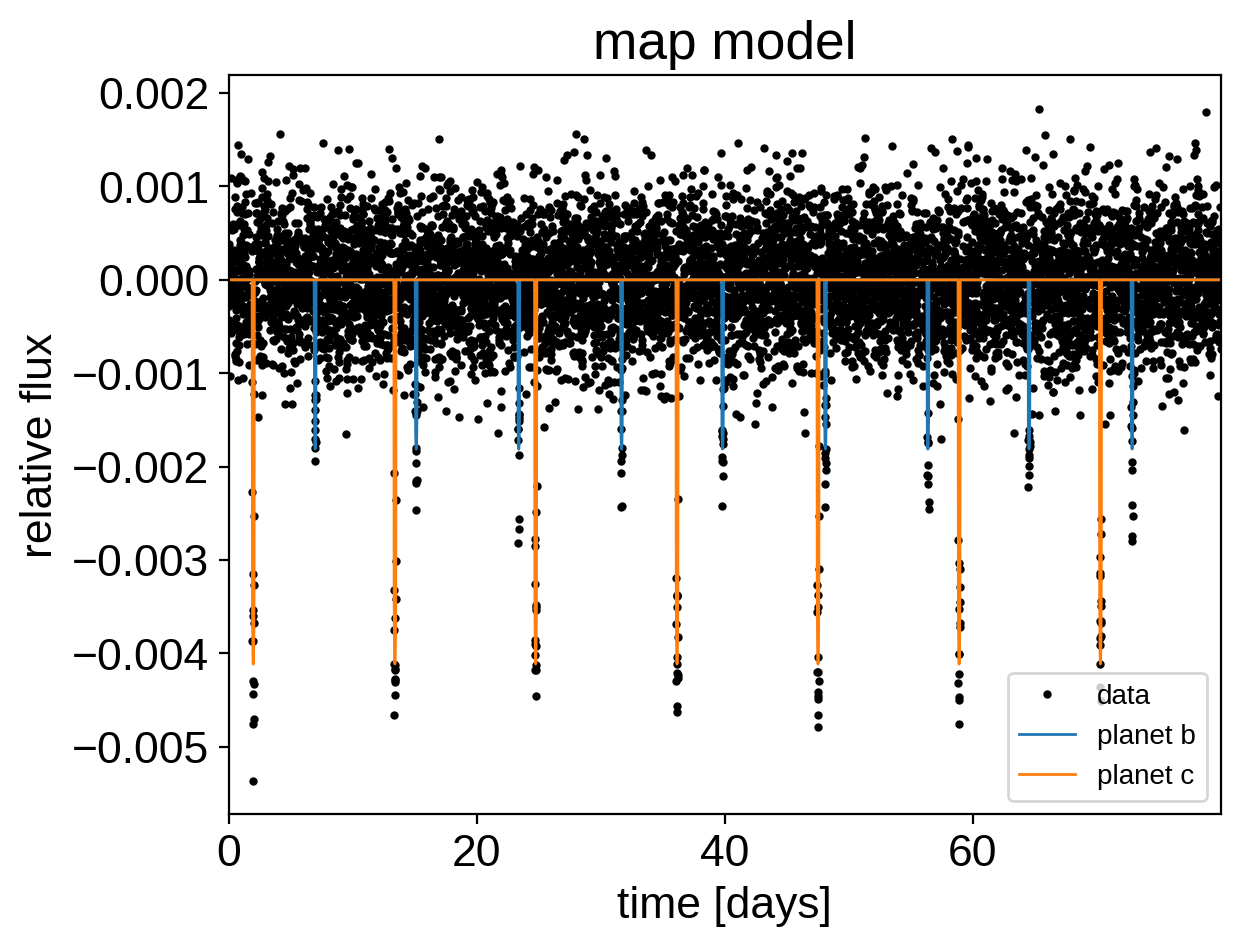

In [5]:
plt.plot(t, y, ".k", ms=4, label="data")
for i, l in enumerate("bc"):
    plt.plot(t, map_soln["light_curves"][:, i], lw=1, label="planet {0}".format(l))
plt.xlim(t.min(), t.max())
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.legend(fontsize=10)
plt.title("map model");

This looks similar to the light curve from the :ref:`transit` tutorial, but if we try plotting the folded transits, we can see that something isn't right: these transits look pretty smeared out!

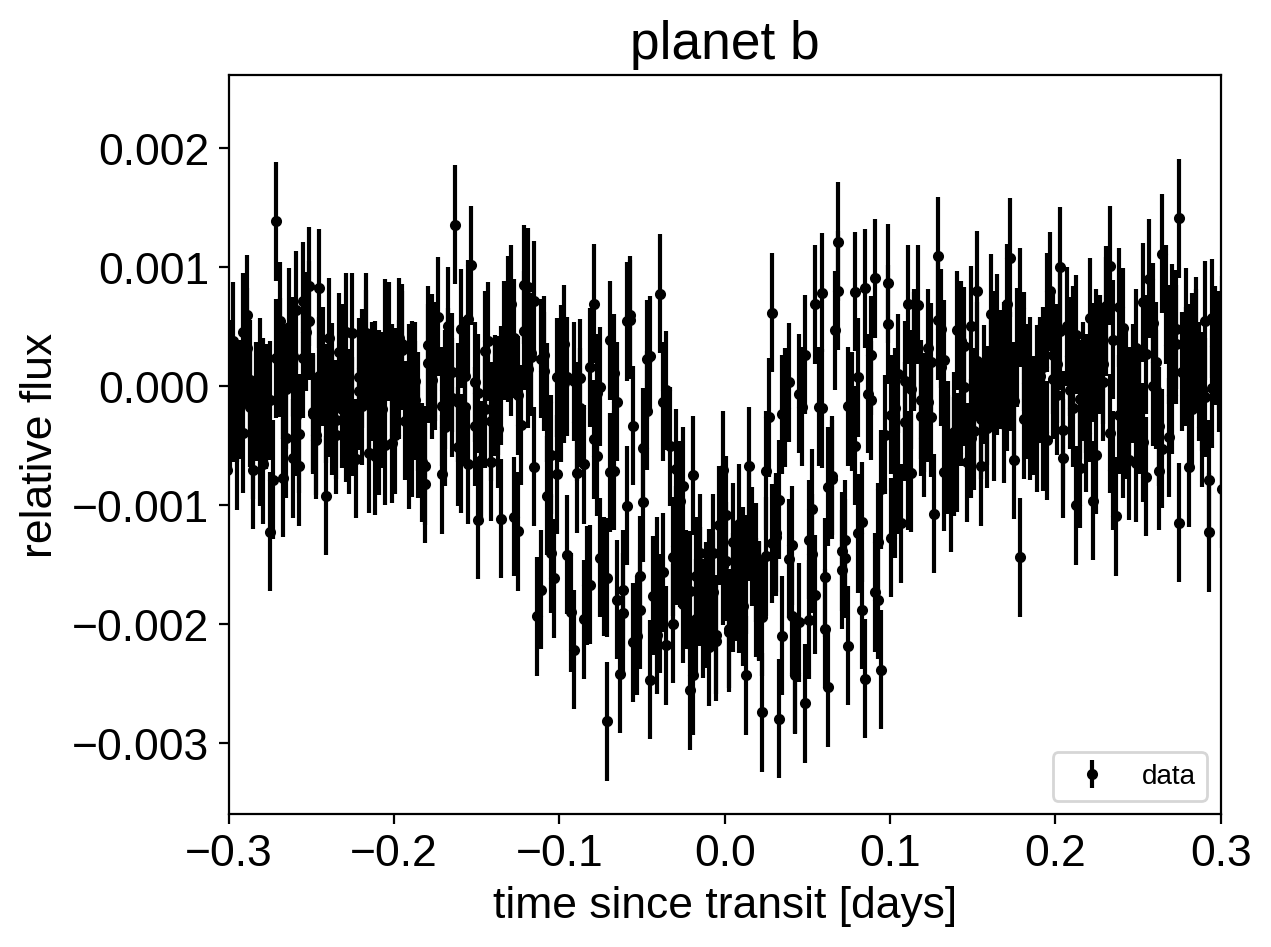

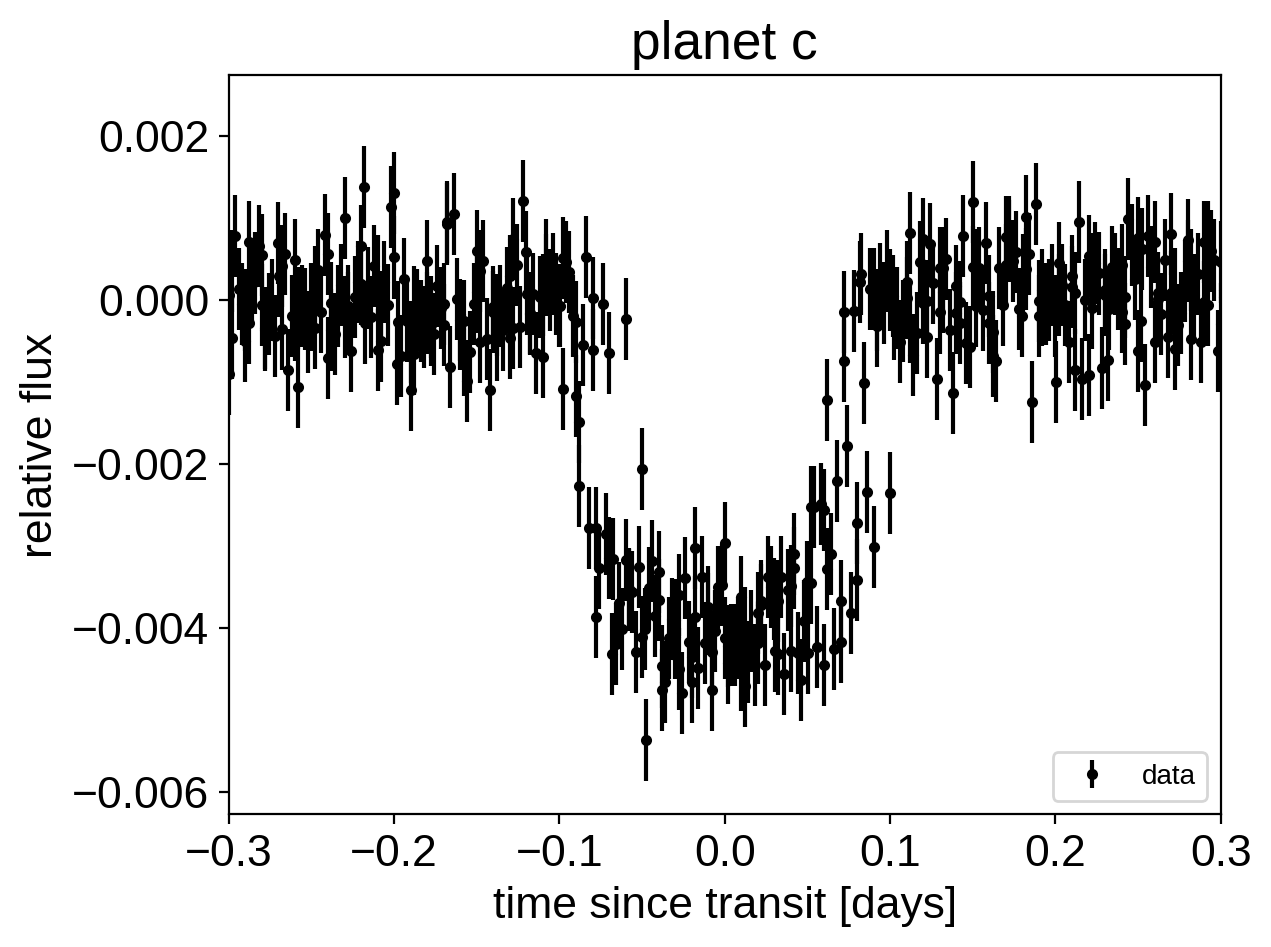

In [6]:
for n, letter in enumerate("bc"):
    plt.figure()

    # Get the posterior median orbital parameters
    p = map_soln["period"][n]
    t0 = map_soln["t0"][n]

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    other = map_soln["light_curves"][:, (n + 1) % 2]

    # Plot the folded data
    x_fold = (t - t0 + 0.5 * p) % p - 0.5 * p
    plt.errorbar(x_fold, y - other, yerr=yerr, fmt=".k", label="data", zorder=-1000)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("relative flux")
    plt.title("planet {0}".format(letter))
    plt.xlim(-0.3, 0.3)

Instead, we can correct for the transit times by removing the best fit transit times and plot that instead:

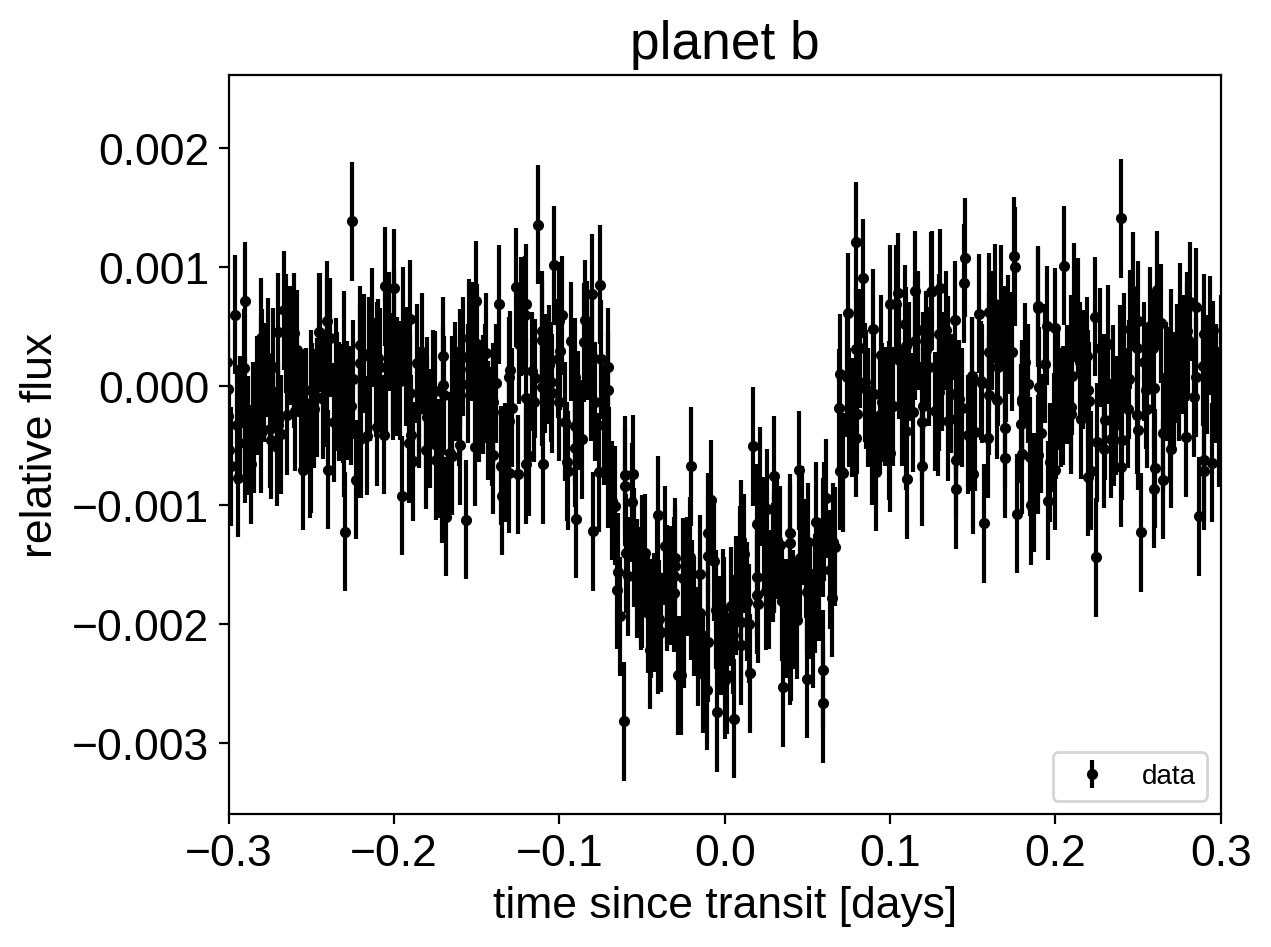

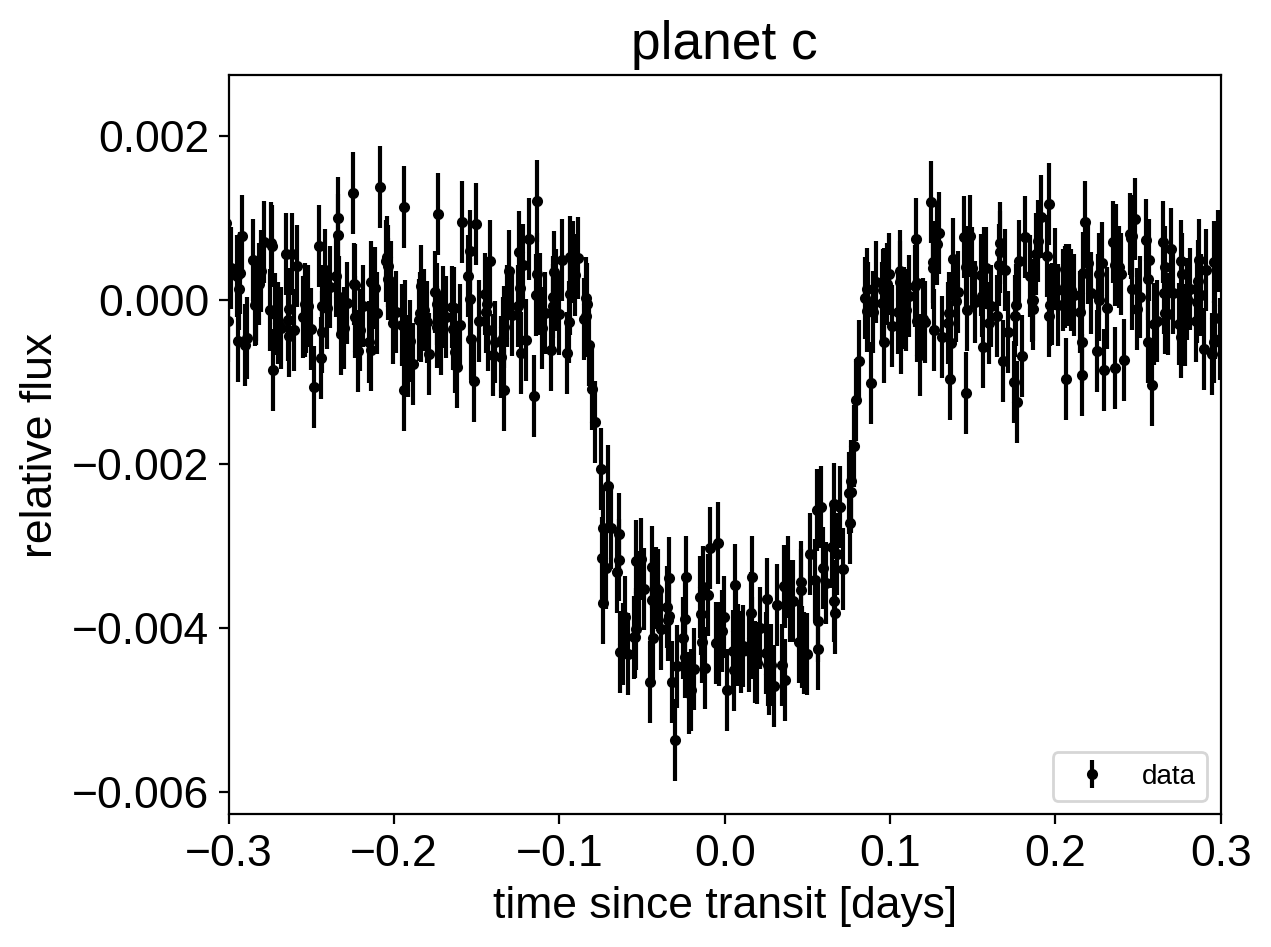

In [7]:
with model:
    t_warp = xo.eval_in_model(orbit._warp_times(t), map_soln)

for n, letter in enumerate("bc"):
    plt.figure()

    p = map_soln["period"][n]
    other = map_soln["light_curves"][:, (n + 1) % 2]

    # NOTE: 't0' has already been subtracted!
    x_fold = (t_warp[:, n] + 0.5 * p) % p - 0.5 * p
    plt.errorbar(x_fold, y - other, yerr=yerr, fmt=".k", label="data", zorder=-1000)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("relative flux")
    plt.title("planet {0}".format(letter))
    plt.xlim(-0.3, 0.3)

That looks better!

## Sampling

Now let's run some MCMC as usual:

In [8]:
np.random.seed(230948)
with model:
    trace = pm.sample(
        tune=1000,
        draws=1000,
        start=map_soln,
        step=xo.get_dense_nuts_step(target_accept=0.9),
    )

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [tts_1, tts_0, b, logr, u, mean]


Sampling 4 chains, 0 divergences:   0%|          | 0/8000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 21/8000 [00:00<02:52, 46.31draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 25/8000 [00:00<05:53, 22.57draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 29/8000 [00:01<08:15, 16.10draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 33/8000 [00:01<09:39, 13.75draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 36/8000 [00:01<08:08, 16.30draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 38/8000 [00:02<12:38, 10.50draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 41/8000 [00:02<14:49,  8.95draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 44/8000 [00:02<11:56, 11.10draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 46/8000 [00:03<15:00,  8.83draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 48/8000 [00:03<12:36, 10.51draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 50/8000 [00:03<15:04,  8.79draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 53/8000 [00:03<15:39,  8.46draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 55/8000 [00:03<14:09,  9.35draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 57/8000 [00:04<16:27,  8.04draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 59/8000 [00:04<13:38,  9.70draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 61/8000 [00:04<16:27,  8.04draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 65/8000 [00:04<12:59, 10.18draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 67/8000 [00:05<15:44,  8.40draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 70/8000 [00:05<16:33,  7.98draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 76/8000 [00:06<14:39,  9.01draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 80/8000 [00:06<14:17,  9.24draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 83/8000 [00:06<11:27, 11.52draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 85/8000 [00:06<15:02,  8.77draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 87/8000 [00:07<12:32, 10.51draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 89/8000 [00:07<14:48,  8.91draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 91/8000 [00:07<13:24,  9.83draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 93/8000 [00:07<14:41,  8.97draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 95/8000 [00:07<13:27,  9.79draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 97/8000 [00:08<14:17,  9.21draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 99/8000 [00:08<13:23,  9.83draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 101/8000 [00:08<14:33,  9.04draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 102/8000 [00:08<14:39,  8.98draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 104/8000 [00:09<15:27,  8.51draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 106/8000 [00:09<12:53, 10.21draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 109/8000 [00:09<13:17,  9.89draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 111/8000 [00:09<12:51, 10.22draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 113/8000 [00:09<13:45,  9.55draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 115/8000 [00:10<13:36,  9.65draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 117/8000 [00:10<14:03,  9.35draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 118/8000 [00:10<15:23,  8.54draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 121/8000 [00:10<14:07,  9.29draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 122/8000 [00:10<15:23,  8.53draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 124/8000 [00:11<13:38,  9.62draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 126/8000 [00:11<14:32,  9.02draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 128/8000 [00:11<12:17, 10.67draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 130/8000 [00:11<13:53,  9.45draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 133/8000 [00:11<11:40, 11.22draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 135/8000 [00:12<13:27,  9.74draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 137/8000 [00:12<13:16,  9.88draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 139/8000 [00:12<15:12,  8.61draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 142/8000 [00:12<12:11, 10.74draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 144/8000 [00:12<14:40,  8.92draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 146/8000 [00:13<12:13, 10.70draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 148/8000 [00:13<17:13,  7.60draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 151/8000 [00:13<13:52,  9.43draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 153/8000 [00:14<16:12,  8.07draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 156/8000 [00:14<13:59,  9.35draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 158/8000 [00:14<14:18,  9.14draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 160/8000 [00:14<14:24,  9.07draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 162/8000 [00:14<15:56,  8.20draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 164/8000 [00:15<13:40,  9.55draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 166/8000 [00:15<15:28,  8.44draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 168/8000 [00:15<13:01, 10.03draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 170/8000 [00:15<15:31,  8.40draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 172/8000 [00:15<13:20,  9.78draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 174/8000 [00:16<15:20,  8.50draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 176/8000 [00:16<12:56, 10.07draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 178/8000 [00:16<15:13,  8.56draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 180/8000 [00:16<12:48, 10.18draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 182/8000 [00:17<16:01,  8.13draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 185/8000 [00:17<15:43,  8.29draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 187/8000 [00:17<13:31,  9.63draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 189/8000 [00:17<16:24,  7.93draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 192/8000 [00:18<12:58, 10.03draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 194/8000 [00:18<16:42,  7.78draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 197/8000 [00:18<13:12,  9.85draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 199/8000 [00:18<16:08,  8.05draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 201/8000 [00:19<14:35,  8.91draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 203/8000 [00:19<15:47,  8.23draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 205/8000 [00:19<14:42,  8.83draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 207/8000 [00:19<15:02,  8.63draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 209/8000 [00:20<13:35,  9.55draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 211/8000 [00:20<14:20,  9.05draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 213/8000 [00:20<13:09,  9.86draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 215/8000 [00:20<14:22,  9.02draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 217/8000 [00:20<13:04,  9.92draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 219/8000 [00:21<14:46,  8.78draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 221/8000 [00:21<12:40, 10.23draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 223/8000 [00:21<14:15,  9.09draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 225/8000 [00:21<12:27, 10.40draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 227/8000 [00:21<14:46,  8.77draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 229/8000 [00:22<13:15,  9.77draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 231/8000 [00:22<14:29,  8.94draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 233/8000 [00:22<13:57,  9.28draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 235/8000 [00:22<14:56,  8.66draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 237/8000 [00:23<14:05,  9.18draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 238/8000 [00:23<16:44,  7.73draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 241/8000 [00:23<15:34,  8.30draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 242/8000 [00:23<16:53,  7.66draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 245/8000 [00:23<14:54,  8.67draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 246/8000 [00:24<17:12,  7.51draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 249/8000 [00:24<15:26,  8.36draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 250/8000 [00:24<16:54,  7.64draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 253/8000 [00:24<15:07,  8.53draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 254/8000 [00:24<17:40,  7.31draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 257/8000 [00:25<15:12,  8.49draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 258/8000 [00:25<17:26,  7.40draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 260/8000 [00:25<14:13,  9.07draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 262/8000 [00:25<15:36,  8.26draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 264/8000 [00:25<14:33,  8.86draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 266/8000 [00:26<14:19,  8.99draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 268/8000 [00:26<14:19,  9.00draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 270/8000 [00:26<13:35,  9.48draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 272/8000 [00:26<15:13,  8.46draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 275/8000 [00:26<12:38, 10.18draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 277/8000 [00:27<14:37,  8.80draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 279/8000 [00:27<12:33, 10.25draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 281/8000 [00:27<14:59,  8.58draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 283/8000 [00:27<12:55,  9.95draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 285/8000 [00:28<14:53,  8.64draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 287/8000 [00:28<12:59,  9.90draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 289/8000 [00:28<15:58,  8.05draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 291/8000 [00:28<15:18,  8.40draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 293/8000 [00:29<14:41,  8.74draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 295/8000 [00:29<14:57,  8.59draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 297/8000 [00:29<14:28,  8.87draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 299/8000 [00:29<15:30,  8.27draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 301/8000 [00:29<13:53,  9.23draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 302/8000 [00:30<16:28,  7.79draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 304/8000 [00:30<13:36,  9.42draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 306/8000 [00:30<15:11,  8.44draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 308/8000 [00:30<13:04,  9.80draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 310/8000 [00:30<14:24,  8.89draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 312/8000 [00:31<12:34, 10.19draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 314/8000 [00:31<15:26,  8.29draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 317/8000 [00:31<15:00,  8.53draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 318/8000 [00:31<14:29,  8.83draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 319/8000 [00:31<15:07,  8.47draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 321/8000 [00:32<14:14,  8.99draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 322/8000 [00:32<14:38,  8.74draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 323/8000 [00:32<14:55,  8.57draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 325/8000 [00:32<13:40,  9.35draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 326/8000 [00:32<15:07,  8.45draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 328/8000 [00:32<12:32, 10.20draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 330/8000 [00:33<15:26,  8.28draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 332/8000 [00:33<13:27,  9.49draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 334/8000 [00:33<15:06,  8.46draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 336/8000 [00:33<12:57,  9.86draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 338/8000 [00:34<14:44,  8.67draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 340/8000 [00:34<13:51,  9.22draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 342/8000 [00:34<13:57,  9.14draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 344/8000 [00:34<13:42,  9.31draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 346/8000 [00:34<13:57,  9.14draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 348/8000 [00:34<11:57, 10.67draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 350/8000 [00:35<14:26,  8.83draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 353/8000 [00:35<11:30, 11.07draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 355/8000 [00:35<13:45,  9.26draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 357/8000 [00:35<11:59, 10.63draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 359/8000 [00:36<13:47,  9.23draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 361/8000 [00:36<12:00, 10.60draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 363/8000 [00:36<15:09,  8.40draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 366/8000 [00:37<15:57,  7.98draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 369/8000 [00:37<12:41, 10.03draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 371/8000 [00:37<15:29,  8.21draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 374/8000 [00:37<16:02,  7.92draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 377/8000 [00:38<13:08,  9.67draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 379/8000 [00:38<15:37,  8.13draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 381/8000 [00:38<13:47,  9.20draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 383/8000 [00:38<15:23,  8.25draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 385/8000 [00:39<14:29,  8.76draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 387/8000 [00:39<15:49,  8.02draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 389/8000 [00:39<16:05,  7.88draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 390/8000 [00:39<15:09,  8.37draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 392/8000 [00:39<12:36, 10.05draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 394/8000 [00:40<14:54,  8.51draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 396/8000 [00:40<13:52,  9.13draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 398/8000 [00:40<15:51,  7.99draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 400/8000 [00:40<13:04,  9.69draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 402/8000 [00:41<15:22,  8.24draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 404/8000 [00:41<13:35,  9.32draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 406/8000 [00:41<16:17,  7.77draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 408/8000 [00:41<13:57,  9.06draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 410/8000 [00:41<14:49,  8.53draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 412/8000 [00:42<13:51,  9.13draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 414/8000 [00:42<14:55,  8.47draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 416/8000 [00:42<12:57,  9.76draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 418/8000 [00:42<15:33,  8.12draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 421/8000 [00:43<12:46,  9.88draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 423/8000 [00:43<15:55,  7.93draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 425/8000 [00:43<15:05,  8.37draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 427/8000 [00:43<14:44,  8.56draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 429/8000 [00:44<14:17,  8.83draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 431/8000 [00:44<16:01,  7.87draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 434/8000 [00:44<13:35,  9.28draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 436/8000 [00:44<15:25,  8.17draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 438/8000 [00:45<13:58,  9.02draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 440/8000 [00:45<15:10,  8.30draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 442/8000 [00:45<14:39,  8.59draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 443/8000 [00:45<19:25,  6.49draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 446/8000 [00:45<16:06,  7.81draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 447/8000 [00:46<21:03,  5.98draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 450/8000 [00:46<16:22,  7.69draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 452/8000 [00:46<18:33,  6.78draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 455/8000 [00:47<17:09,  7.33draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 457/8000 [00:47<15:06,  8.32draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 459/8000 [00:47<15:08,  8.30draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 461/8000 [00:47<16:27,  7.63draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 463/8000 [00:47<14:05,  8.91draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 465/8000 [00:48<15:10,  8.27draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 467/8000 [00:48<12:35,  9.97draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 469/8000 [00:48<15:20,  8.19draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 472/8000 [00:48<12:34,  9.98draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 474/8000 [00:49<14:46,  8.49draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 476/8000 [00:49<12:59,  9.65draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 478/8000 [00:49<14:26,  8.68draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 480/8000 [00:49<13:05,  9.58draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 482/8000 [00:49<14:16,  8.78draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 484/8000 [00:50<12:20, 10.15draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 486/8000 [00:50<14:42,  8.52draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 488/8000 [00:50<12:56,  9.67draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 490/8000 [00:50<13:47,  9.08draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 492/8000 [00:50<12:40,  9.87draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 494/8000 [00:51<14:27,  8.65draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 496/8000 [00:51<12:02, 10.38draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 498/8000 [00:51<13:53,  9.00draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 500/8000 [00:51<12:33,  9.95draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 502/8000 [00:52<14:22,  8.69draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 504/8000 [00:52<12:03, 10.36draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 506/8000 [00:52<14:53,  8.39draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 509/8000 [00:52<15:36,  8.00draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 512/8000 [00:53<12:28, 10.00draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 514/8000 [00:53<16:10,  7.72draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 517/8000 [00:53<15:48,  7.89draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 521/8000 [00:54<15:38,  7.97draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 525/8000 [00:54<14:44,  8.45draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 528/8000 [00:54<11:47, 10.57draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 530/8000 [00:55<16:02,  7.76draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 533/8000 [00:55<16:03,  7.75draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 535/8000 [00:55<13:21,  9.31draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 537/8000 [00:56<16:08,  7.70draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 539/8000 [00:56<13:26,  9.25draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 541/8000 [00:56<15:06,  8.23draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 543/8000 [00:56<14:25,  8.61draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 545/8000 [00:57<14:45,  8.42draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 547/8000 [00:57<14:33,  8.54draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 549/8000 [00:57<14:13,  8.73draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 551/8000 [00:57<13:22,  9.29draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 552/8000 [00:57<13:31,  9.17draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 553/8000 [00:57<13:22,  9.28draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 555/8000 [00:58<13:24,  9.25draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 557/8000 [00:58<12:07, 10.23draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 559/8000 [00:58<15:05,  8.21draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 562/8000 [00:58<12:19, 10.06draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 564/8000 [00:59<15:46,  7.86draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 567/8000 [00:59<14:58,  8.27draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 569/8000 [00:59<13:49,  8.96draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 571/8000 [00:59<13:47,  8.98draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 573/8000 [01:00<14:07,  8.76draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 575/8000 [01:00<13:38,  9.07draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 576/8000 [01:00<17:52,  6.92draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 579/8000 [01:00<15:03,  8.21draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 581/8000 [01:01<15:40,  7.89draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 583/8000 [01:01<15:28,  7.99draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 584/8000 [01:01<15:43,  7.86draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 586/8000 [01:01<14:21,  8.61draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 587/8000 [01:01<16:06,  7.67draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 588/8000 [01:01<15:14,  8.10draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 589/8000 [01:01<16:06,  7.66draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 591/8000 [01:02<14:42,  8.40draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 593/8000 [01:02<12:52,  9.59draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 595/8000 [01:02<15:17,  8.07draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 598/8000 [01:02<13:07,  9.40draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 601/8000 [01:02<10:53, 11.32draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 603/8000 [01:03<12:30,  9.86draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 605/8000 [01:03<11:23, 10.82draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 607/8000 [01:03<11:56, 10.31draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 609/8000 [01:03<10:17, 11.97draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 611/8000 [01:03<11:06, 11.09draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 615/8000 [01:04<09:37, 12.79draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 617/8000 [01:04<12:18, 10.00draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 619/8000 [01:04<10:42, 11.48draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 621/8000 [01:04<09:43, 12.64draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 623/8000 [01:04<09:41, 12.68draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 626/8000 [01:05<09:04, 13.54draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 630/8000 [01:05<07:35, 16.17draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 634/8000 [01:05<06:55, 17.71draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 637/8000 [01:05<06:40, 18.39draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 640/8000 [01:05<07:13, 16.97draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 642/8000 [01:05<07:27, 16.45draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 646/8000 [01:06<07:21, 16.64draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 649/8000 [01:06<06:24, 19.13draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 652/8000 [01:06<07:28, 16.40draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 655/8000 [01:06<06:55, 17.69draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 657/8000 [01:06<07:23, 16.57draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 660/8000 [01:06<06:51, 17.83draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 664/8000 [01:06<06:09, 19.86draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 667/8000 [01:07<05:33, 21.99draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 670/8000 [01:07<05:27, 22.41draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 675/8000 [01:07<04:58, 24.58draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 679/8000 [01:07<05:09, 23.69draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 682/8000 [01:07<04:55, 24.73draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 687/8000 [01:07<04:23, 27.71draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 690/8000 [01:07<04:52, 25.03draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 696/8000 [01:08<04:05, 29.77draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 700/8000 [01:08<03:53, 31.25draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 706/8000 [01:08<03:40, 33.14draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 713/8000 [01:08<03:16, 37.03draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 720/8000 [01:08<02:50, 42.78draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 726/8000 [01:08<02:39, 45.68draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 732/8000 [01:08<02:36, 46.59draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 740/8000 [01:08<02:28, 48.96draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 746/8000 [01:09<02:24, 50.33draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 752/8000 [01:09<02:41, 44.82draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 757/8000 [01:09<02:37, 46.05draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 763/8000 [01:09<02:31, 47.70draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 771/8000 [01:09<02:21, 51.17draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 781/8000 [01:09<02:03, 58.25draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 789/8000 [01:09<01:53, 63.40draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 798/8000 [01:09<01:48, 66.50draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 808/8000 [01:09<01:40, 71.79draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 816/8000 [01:10<01:41, 70.70draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 824/8000 [01:10<01:40, 71.28draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 832/8000 [01:10<01:43, 69.37draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 844/8000 [01:10<01:30, 79.39draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 853/8000 [01:10<01:39, 71.62draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 863/8000 [01:10<01:36, 73.97draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 873/8000 [01:10<01:32, 77.15draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 884/8000 [01:10<01:24, 84.15draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 893/8000 [01:11<01:26, 82.49draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 905/8000 [01:11<01:18, 89.85draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 915/8000 [01:11<01:16, 92.53draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 925/8000 [01:11<01:22, 85.93draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 936/8000 [01:11<01:21, 86.51draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 945/8000 [01:11<01:22, 85.96draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 955/8000 [01:11<01:19, 88.82draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 966/8000 [01:11<01:15, 93.36draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 982/8000 [01:11<01:07, 104.06draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 993/8000 [01:12<01:10, 99.08draws/s] 

Sampling 4 chains, 0 divergences:  13%|█▎        | 1004/8000 [01:12<01:09, 99.97draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 1015/8000 [01:12<01:10, 98.65draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 1027/8000 [01:12<01:07, 103.75draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 1038/8000 [01:12<01:08, 102.03draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 1051/8000 [01:12<01:04, 107.19draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 1068/8000 [01:12<00:57, 120.10draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 1081/8000 [01:12<00:56, 122.81draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 1094/8000 [01:12<00:55, 124.70draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 1107/8000 [01:13<00:56, 122.13draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 1122/8000 [01:13<00:53, 128.76draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 1136/8000 [01:13<00:52, 130.35draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 1150/8000 [01:13<00:51, 133.05draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 1164/8000 [01:13<00:50, 134.09draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 1178/8000 [01:13<00:52, 130.31draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 1192/8000 [01:13<00:53, 127.93draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 1206/8000 [01:13<00:52, 129.54draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 1220/8000 [01:13<00:51, 132.50draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 1235/8000 [01:13<00:50, 133.44draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 1252/8000 [01:14<00:47, 142.17draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 1271/8000 [01:14<00:43, 153.45draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 1289/8000 [01:14<00:42, 157.96draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 1307/8000 [01:14<00:40, 163.86draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 1324/8000 [01:14<00:41, 159.87draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 1341/8000 [01:14<00:42, 155.05draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 1357/8000 [01:14<00:43, 152.24draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 1373/8000 [01:14<00:43, 153.44draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 1389/8000 [01:14<00:44, 147.46draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 1404/8000 [01:15<00:46, 143.13draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 1419/8000 [01:15<00:45, 143.24draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 1434/8000 [01:15<00:46, 141.17draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 1450/8000 [01:15<00:45, 145.27draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 1465/8000 [01:15<00:45, 143.63draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 1480/8000 [01:15<00:45, 141.93draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 1495/8000 [01:15<00:46, 139.82draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 1511/8000 [01:15<00:45, 143.88draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 1527/8000 [01:15<00:44, 146.85draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 1542/8000 [01:16<00:46, 139.47draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 1557/8000 [01:16<00:46, 138.44draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 1573/8000 [01:16<00:45, 141.26draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 1588/8000 [01:16<00:46, 138.63draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 1602/8000 [01:16<00:46, 136.35draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 1619/8000 [01:16<00:44, 144.14draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 1634/8000 [01:16<00:43, 144.84draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 1652/8000 [01:16<00:42, 149.24draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 1670/8000 [01:16<00:41, 151.64draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 1686/8000 [01:16<00:41, 151.00draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 1702/8000 [01:17<00:41, 151.50draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 1718/8000 [01:17<00:44, 141.07draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 1734/8000 [01:17<00:42, 146.20draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 1749/8000 [01:17<00:44, 139.84draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 1764/8000 [01:17<00:45, 136.09draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 1778/8000 [01:17<00:46, 134.28draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 1794/8000 [01:17<00:44, 140.56draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 1809/8000 [01:17<00:44, 139.82draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 1824/8000 [01:18<00:45, 134.36draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 1838/8000 [01:18<00:46, 131.84draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 1852/8000 [01:18<00:47, 129.98draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 1866/8000 [01:18<00:46, 131.08draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 1884/8000 [01:18<00:43, 141.88draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 1899/8000 [01:18<00:42, 142.65draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 1916/8000 [01:18<00:40, 149.28draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 1933/8000 [01:18<00:39, 152.65draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 1951/8000 [01:18<00:38, 159.09draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 1968/8000 [01:18<00:38, 157.64draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 1984/8000 [01:19<00:38, 156.35draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 2001/8000 [01:19<00:37, 159.18draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 2018/8000 [01:19<00:37, 159.82draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 2035/8000 [01:19<00:39, 151.75draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 2051/8000 [01:19<00:39, 152.45draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 2067/8000 [01:19<00:39, 149.22draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 2082/8000 [01:19<00:40, 144.41draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 2099/8000 [01:19<00:39, 150.50draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 2116/8000 [01:19<00:38, 154.04draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 2135/8000 [01:20<00:36, 162.55draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 2157/8000 [01:20<00:34, 169.49draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 2175/8000 [01:20<00:34, 167.20draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 2194/8000 [01:20<00:33, 171.45draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 2212/8000 [01:20<00:36, 157.42draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 2229/8000 [01:20<00:37, 152.78draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 2245/8000 [01:20<00:39, 146.43draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 2262/8000 [01:20<00:39, 145.40draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 2278/8000 [01:20<00:39, 146.02draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 2293/8000 [01:21<00:38, 146.53draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 2308/8000 [01:21<00:39, 144.86draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 2326/8000 [01:21<00:38, 148.71draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 2343/8000 [01:21<00:36, 153.74draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 2359/8000 [01:21<00:36, 155.32draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 2375/8000 [01:21<00:36, 152.71draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 2391/8000 [01:21<00:37, 148.73draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 2407/8000 [01:21<00:37, 150.37draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 2423/8000 [01:21<00:37, 147.26draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 2438/8000 [01:22<00:38, 144.90draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 2453/8000 [01:22<00:38, 145.68draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 2468/8000 [01:22<00:38, 145.50draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 2483/8000 [01:22<00:38, 145.03draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 2498/8000 [01:22<00:38, 141.54draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 2515/8000 [01:22<00:37, 147.56draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 2531/8000 [01:22<00:36, 148.61draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 2546/8000 [01:22<00:38, 141.38draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 2561/8000 [01:22<00:39, 138.03draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 2575/8000 [01:23<00:39, 137.30draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 2589/8000 [01:23<00:39, 135.72draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 2606/8000 [01:23<00:37, 144.32draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 2622/8000 [01:23<00:36, 147.63draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 2639/8000 [01:23<00:35, 152.28draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 2655/8000 [01:23<00:35, 150.69draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 2671/8000 [01:23<00:34, 153.07draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 2690/8000 [01:23<00:32, 161.01draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 2707/8000 [01:23<00:32, 160.45draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 2724/8000 [01:23<00:33, 156.77draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 2741/8000 [01:24<00:32, 160.44draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 2760/8000 [01:24<00:31, 167.99draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 2779/8000 [01:24<00:30, 168.50draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 2798/8000 [01:24<00:30, 169.80draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 2816/8000 [01:24<00:31, 166.66draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 2833/8000 [01:24<00:31, 165.03draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 2850/8000 [01:24<00:31, 162.25draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 2867/8000 [01:24<00:32, 157.39draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 2883/8000 [01:24<00:33, 151.65draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 2899/8000 [01:25<00:35, 144.81draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 2914/8000 [01:25<00:36, 140.86draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 2932/8000 [01:25<00:33, 149.28draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 2951/8000 [01:25<00:32, 153.06draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 2969/8000 [01:25<00:31, 159.02draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 2986/8000 [01:25<00:31, 161.25draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 3003/8000 [01:25<00:31, 157.87draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 3019/8000 [01:25<00:32, 151.39draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 3036/8000 [01:25<00:32, 154.76draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 3052/8000 [01:26<00:32, 153.03draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 3069/8000 [01:26<00:32, 151.94draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 3088/8000 [01:26<00:30, 159.61draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 3107/8000 [01:26<00:29, 166.16draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 3124/8000 [01:26<00:29, 165.42draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 3141/8000 [01:26<00:30, 160.44draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 3158/8000 [01:26<00:29, 161.93draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 3176/8000 [01:26<00:29, 166.09draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 3196/8000 [01:26<00:27, 174.72draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 3214/8000 [01:26<00:27, 171.97draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 3232/8000 [01:27<00:28, 169.85draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 3250/8000 [01:27<00:27, 172.35draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 3268/8000 [01:27<00:28, 163.27draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 3285/8000 [01:27<00:29, 160.06draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 3302/8000 [01:27<00:29, 161.54draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 3319/8000 [01:27<00:30, 153.00draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 3335/8000 [01:27<00:31, 148.99draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 3351/8000 [01:27<00:32, 141.48draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 3366/8000 [01:28<00:32, 142.48draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 3387/8000 [01:28<00:29, 155.79draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 3409/8000 [01:28<00:27, 169.19draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 3427/8000 [01:28<00:28, 161.32draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 3444/8000 [01:28<00:29, 155.31draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 3460/8000 [01:28<00:30, 150.95draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 3476/8000 [01:28<00:30, 150.80draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 3492/8000 [01:28<00:29, 151.06draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 3508/8000 [01:28<00:29, 150.00draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 3524/8000 [01:29<00:30, 147.48draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 3540/8000 [01:29<00:29, 150.94draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 3556/8000 [01:29<00:29, 148.38draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 3571/8000 [01:29<00:30, 146.77draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 3586/8000 [01:29<00:30, 143.51draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 3602/8000 [01:29<00:30, 144.96draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 3618/8000 [01:29<00:30, 145.52draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 3636/8000 [01:29<00:29, 147.85draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 3651/8000 [01:29<00:30, 140.44draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 3667/8000 [01:29<00:29, 145.03draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 3682/8000 [01:30<00:29, 145.46draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 3697/8000 [01:30<00:29, 145.88draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 3714/8000 [01:30<00:28, 151.01draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 3730/8000 [01:30<00:28, 150.07draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 3748/8000 [01:30<00:27, 156.17draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 3765/8000 [01:30<00:26, 159.36draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 3782/8000 [01:30<00:27, 154.19draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 3801/8000 [01:30<00:25, 161.91draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 3818/8000 [01:30<00:28, 149.11draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 3834/8000 [01:31<00:28, 148.08draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 3850/8000 [01:31<00:28, 144.78draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 3867/8000 [01:31<00:27, 149.54draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 3883/8000 [01:31<00:27, 148.42draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 3898/8000 [01:31<00:28, 142.56draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 3913/8000 [01:31<00:28, 142.20draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 3928/8000 [01:31<00:29, 139.99draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 3943/8000 [01:31<00:28, 140.27draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 3960/8000 [01:31<00:27, 147.76draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 3977/8000 [01:32<00:26, 151.15draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 3993/8000 [01:32<00:26, 149.56draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 4009/8000 [01:32<00:26, 149.07draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 4024/8000 [01:32<00:27, 146.86draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 4039/8000 [01:32<00:26, 147.41draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 4055/8000 [01:32<00:26, 148.62draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 4072/8000 [01:32<00:25, 153.24draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 4090/8000 [01:32<00:24, 159.38draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 4107/8000 [01:32<00:24, 161.77draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 4124/8000 [01:32<00:24, 161.28draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 4141/8000 [01:33<00:23, 163.18draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 4158/8000 [01:33<00:25, 152.76draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 4176/8000 [01:33<00:24, 159.29draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 4193/8000 [01:33<00:24, 157.31draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 4209/8000 [01:33<00:24, 154.44draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 4225/8000 [01:33<00:25, 150.96draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 4241/8000 [01:33<00:25, 148.28draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 4256/8000 [01:33<00:25, 148.26draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 4273/8000 [01:33<00:25, 148.70draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 4289/8000 [01:34<00:24, 151.45draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 4305/8000 [01:34<00:24, 152.85draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 4321/8000 [01:34<00:24, 152.35draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 4337/8000 [01:34<00:23, 153.78draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 4353/8000 [01:34<00:23, 153.30draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 4369/8000 [01:34<00:23, 151.41draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 4385/8000 [01:34<00:24, 148.22draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 4401/8000 [01:34<00:23, 151.11draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 4417/8000 [01:34<00:24, 144.71draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 4432/8000 [01:35<00:24, 144.91draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 4447/8000 [01:35<00:24, 145.14draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 4462/8000 [01:35<00:24, 146.49draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 4477/8000 [01:35<00:24, 146.19draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 4493/8000 [01:35<00:23, 148.77draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 4508/8000 [01:35<00:24, 141.43draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 4523/8000 [01:35<00:25, 137.38draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 4538/8000 [01:35<00:24, 139.15draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 4554/8000 [01:35<00:24, 140.86draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 4570/8000 [01:36<00:24, 141.98draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 4588/8000 [01:36<00:22, 150.64draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 4604/8000 [01:36<00:22, 148.44draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 4620/8000 [01:36<00:23, 144.69draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 4636/8000 [01:36<00:22, 148.44draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 4651/8000 [01:36<00:22, 146.52draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 4666/8000 [01:36<00:22, 146.68draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 4681/8000 [01:36<00:23, 142.43draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 4697/8000 [01:36<00:23, 140.27draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 4712/8000 [01:36<00:23, 138.94draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 4726/8000 [01:37<00:23, 136.51draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 4741/8000 [01:37<00:23, 138.58draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 4755/8000 [01:37<00:23, 136.25draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 4769/8000 [01:37<00:23, 134.67draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 4783/8000 [01:37<00:24, 131.97draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 4799/8000 [01:37<00:23, 137.41draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 4813/8000 [01:37<00:23, 136.13draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 4827/8000 [01:37<00:23, 135.70draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 4842/8000 [01:37<00:22, 137.77draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 4859/8000 [01:38<00:21, 144.21draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 4874/8000 [01:38<00:22, 139.41draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 4890/8000 [01:38<00:21, 143.87draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 4906/8000 [01:38<00:20, 147.63draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 4921/8000 [01:38<00:21, 142.17draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 4936/8000 [01:38<00:21, 140.85draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 4951/8000 [01:38<00:21, 140.39draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 4966/8000 [01:38<00:21, 141.83draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 4981/8000 [01:38<00:21, 143.23draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 4996/8000 [01:39<00:20, 144.89draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 5013/8000 [01:39<00:20, 148.59draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 5028/8000 [01:39<00:20, 145.29draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 5043/8000 [01:39<00:20, 143.25draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 5058/8000 [01:39<00:20, 142.93draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 5073/8000 [01:39<00:20, 143.12draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 5088/8000 [01:39<00:20, 142.33draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 5103/8000 [01:39<00:20, 143.63draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 5118/8000 [01:39<00:21, 135.74draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 5133/8000 [01:39<00:20, 139.67draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 5148/8000 [01:40<00:20, 139.52draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 5163/8000 [01:40<00:20, 138.91draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 5178/8000 [01:40<00:19, 141.79draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 5194/8000 [01:40<00:19, 142.09draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 5210/8000 [01:40<00:19, 146.76draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 5225/8000 [01:40<00:19, 144.86draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 5240/8000 [01:40<00:19, 141.04draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 5255/8000 [01:40<00:19, 139.07draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 5269/8000 [01:40<00:19, 137.63draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 5283/8000 [01:41<00:20, 134.18draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 5300/8000 [01:41<00:18, 142.49draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 5315/8000 [01:41<00:19, 141.10draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 5330/8000 [01:41<00:18, 140.79draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 5345/8000 [01:41<00:19, 139.63draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 5361/8000 [01:41<00:18, 140.77draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 5380/8000 [01:41<00:17, 148.05draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 5395/8000 [01:41<00:17, 145.88draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 5410/8000 [01:41<00:18, 139.33draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 5425/8000 [01:42<00:18, 137.40draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 5441/8000 [01:42<00:18, 139.65draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 5457/8000 [01:42<00:17, 144.10draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 5472/8000 [01:42<00:17, 143.29draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 5487/8000 [01:42<00:17, 140.48draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 5503/8000 [01:42<00:17, 145.20draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 5518/8000 [01:42<00:17, 145.00draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 5533/8000 [01:42<00:17, 141.17draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 5548/8000 [01:42<00:17, 140.44draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 5564/8000 [01:43<00:16, 145.20draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 5579/8000 [01:43<00:16, 146.47draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 5594/8000 [01:43<00:16, 146.05draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 5609/8000 [01:43<00:16, 146.50draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 5627/8000 [01:43<00:15, 150.41draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 5643/8000 [01:43<00:16, 146.56draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 5658/8000 [01:43<00:16, 144.28draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 5674/8000 [01:43<00:16, 142.68draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 5689/8000 [01:43<00:15, 144.75draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 5704/8000 [01:43<00:16, 143.40draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 5719/8000 [01:44<00:16, 140.75draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 5735/8000 [01:44<00:15, 145.86draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 5752/8000 [01:44<00:15, 149.11draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 5771/8000 [01:44<00:14, 158.14draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 5788/8000 [01:44<00:13, 160.38draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 5805/8000 [01:44<00:14, 154.43draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 5821/8000 [01:44<00:14, 154.91draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 5837/8000 [01:44<00:14, 153.24draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 5853/8000 [01:44<00:13, 153.40draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 5869/8000 [01:45<00:13, 154.04draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 5885/8000 [01:45<00:13, 154.34draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 5901/8000 [01:45<00:14, 148.60draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 5916/8000 [01:45<00:14, 146.90draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 5933/8000 [01:45<00:13, 149.96draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 5949/8000 [01:45<00:13, 151.21draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 5965/8000 [01:45<00:13, 152.74draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 5981/8000 [01:45<00:13, 148.78draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 5997/8000 [01:45<00:13, 151.92draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 6013/8000 [01:46<00:13, 147.49draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 6028/8000 [01:46<00:13, 142.16draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 6043/8000 [01:46<00:14, 139.75draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 6058/8000 [01:46<00:14, 138.02draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 6072/8000 [01:46<00:14, 135.22draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 6086/8000 [01:46<00:14, 135.89draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 6100/8000 [01:46<00:14, 133.15draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 6114/8000 [01:46<00:13, 135.04draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 6128/8000 [01:46<00:13, 133.96draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 6143/8000 [01:46<00:14, 132.11draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 6160/8000 [01:47<00:13, 137.68draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 6176/8000 [01:47<00:12, 143.57draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 6191/8000 [01:47<00:13, 137.23draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 6207/8000 [01:47<00:12, 139.13draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 6223/8000 [01:47<00:12, 140.78draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 6238/8000 [01:47<00:12, 137.66draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 6253/8000 [01:47<00:12, 140.13draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 6268/8000 [01:47<00:12, 142.67draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 6283/8000 [01:47<00:12, 136.52draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 6297/8000 [01:48<00:12, 131.41draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 6313/8000 [01:48<00:12, 138.76draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 6328/8000 [01:48<00:11, 140.50draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 6343/8000 [01:48<00:11, 142.24draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 6358/8000 [01:48<00:11, 143.68draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 6375/8000 [01:48<00:10, 149.58draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 6391/8000 [01:48<00:11, 141.14draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 6407/8000 [01:48<00:10, 145.76draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 6422/8000 [01:48<00:10, 146.27draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 6438/8000 [01:49<00:10, 143.75draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 6453/8000 [01:49<00:10, 145.03draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 6469/8000 [01:49<00:10, 144.30draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 6484/8000 [01:49<00:10, 145.53draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 6501/8000 [01:49<00:09, 150.69draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 6517/8000 [01:49<00:09, 152.18draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 6533/8000 [01:49<00:09, 151.69draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 6549/8000 [01:49<00:09, 153.22draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 6565/8000 [01:49<00:09, 149.30draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 6581/8000 [01:49<00:09, 150.61draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 6597/8000 [01:50<00:09, 147.42draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 6612/8000 [01:50<00:09, 146.97draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 6629/8000 [01:50<00:09, 150.61draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 6645/8000 [01:50<00:09, 149.69draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 6660/8000 [01:50<00:08, 149.55draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 6677/8000 [01:50<00:08, 152.33draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 6694/8000 [01:50<00:08, 149.98draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 6711/8000 [01:50<00:08, 154.89draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 6729/8000 [01:50<00:08, 156.59draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 6748/8000 [01:51<00:07, 161.86draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 6765/8000 [01:51<00:07, 158.31draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 6781/8000 [01:51<00:07, 156.38draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 6797/8000 [01:51<00:07, 156.12draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 6813/8000 [01:51<00:07, 157.11draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 6829/8000 [01:51<00:07, 152.33draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 6845/8000 [01:51<00:07, 146.90draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 6860/8000 [01:51<00:07, 146.28draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 6875/8000 [01:51<00:07, 144.19draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 6890/8000 [01:52<00:07, 143.22draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 6906/8000 [01:52<00:07, 146.65draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 6922/8000 [01:52<00:07, 150.29draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 6938/8000 [01:52<00:07, 147.62draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 6953/8000 [01:52<00:07, 147.44draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 6968/8000 [01:52<00:07, 144.24draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 6984/8000 [01:52<00:06, 147.90draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 6999/8000 [01:52<00:06, 147.43draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 7014/8000 [01:52<00:06, 143.35draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 7029/8000 [01:52<00:06, 143.70draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 7044/8000 [01:53<00:06, 143.60draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 7061/8000 [01:53<00:06, 148.72draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 7076/8000 [01:53<00:06, 145.60draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 7093/8000 [01:53<00:05, 151.49draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 7111/8000 [01:53<00:05, 156.42draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 7128/8000 [01:53<00:05, 155.91draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 7147/8000 [01:53<00:05, 163.90draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 7164/8000 [01:53<00:05, 165.51draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 7181/8000 [01:53<00:05, 161.99draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 7198/8000 [01:54<00:05, 159.97draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 7215/8000 [01:54<00:04, 157.39draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 7231/8000 [01:54<00:05, 153.42draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 7247/8000 [01:54<00:04, 153.04draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 7263/8000 [01:54<00:04, 152.07draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 7279/8000 [01:54<00:04, 152.49draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 7295/8000 [01:54<00:04, 147.21draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 7310/8000 [01:54<00:04, 144.15draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 7327/8000 [01:54<00:04, 149.96draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 7344/8000 [01:55<00:04, 150.50draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 7362/8000 [01:55<00:04, 157.66draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 7378/8000 [01:55<00:04, 153.95draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 7394/8000 [01:55<00:03, 152.54draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 7412/8000 [01:55<00:03, 156.66draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 7428/8000 [01:55<00:03, 155.37draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 7444/8000 [01:55<00:03, 152.37draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 7460/8000 [01:55<00:03, 149.98draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 7476/8000 [01:55<00:03, 144.90draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 7491/8000 [01:55<00:03, 145.65draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 7506/8000 [01:56<00:03, 143.41draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 7521/8000 [01:56<00:03, 139.96draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 7536/8000 [01:56<00:03, 139.02draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 7553/8000 [01:56<00:03, 144.59draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 7568/8000 [01:56<00:03, 143.35draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 7583/8000 [01:56<00:02, 139.04draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 7597/8000 [01:56<00:02, 137.33draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 7613/8000 [01:56<00:02, 141.84draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 7629/8000 [01:56<00:02, 145.57draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 7647/8000 [01:57<00:02, 149.16draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 7662/8000 [01:57<00:02, 148.13draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 7677/8000 [01:57<00:02, 143.53draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 7692/8000 [01:57<00:02, 141.30draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 7707/8000 [01:57<00:02, 141.90draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 7722/8000 [01:57<00:01, 139.25draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 7736/8000 [01:57<00:02, 126.83draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 7749/8000 [01:57<00:02, 114.23draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 7761/8000 [01:58<00:02, 112.94draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 7773/8000 [01:58<00:02, 101.81draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 7784/8000 [01:58<00:02, 92.15draws/s] 

Sampling 4 chains, 0 divergences:  97%|█████████▋| 7794/8000 [01:58<00:02, 92.15draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 7804/8000 [01:58<00:02, 91.85draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 7814/8000 [01:58<00:02, 89.05draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 7824/8000 [01:58<00:02, 86.67draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 7833/8000 [01:58<00:01, 85.01draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 7842/8000 [01:58<00:01, 81.46draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 7851/8000 [01:59<00:01, 82.25draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 7860/8000 [01:59<00:01, 82.16draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 7869/8000 [01:59<00:01, 81.50draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 7878/8000 [01:59<00:01, 80.27draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 7887/8000 [01:59<00:01, 76.97draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 7897/8000 [01:59<00:01, 79.50draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 7906/8000 [01:59<00:01, 77.48draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 7915/8000 [01:59<00:01, 78.51draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 7924/8000 [02:00<00:00, 78.77draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 7933/8000 [02:00<00:00, 79.54draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 7941/8000 [02:00<00:00, 78.98draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 7950/8000 [02:00<00:00, 79.34draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 7958/8000 [02:00<00:00, 79.15draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 7966/8000 [02:00<00:00, 76.40draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 7974/8000 [02:00<00:00, 61.66draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 7981/8000 [02:00<00:00, 52.70draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 7987/8000 [02:01<00:00, 47.68draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 7993/8000 [02:01<00:00, 44.75draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 7998/8000 [02:01<00:00, 42.98draws/s]

Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [02:01<00:00, 65.88draws/s]

Then check the convergence diagnostics:

In [9]:
pm.summary(trace, varnames=["mean", "u", "logr", "b", "tts_0", "tts_1"])

/mnt/home/dforeman/research/projects/exoplanet-dev/case-studies/env/lib/python3.7/site-packages/pymc3/stats/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  "pymc3 3.9".format(old=old, new=new)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean,-0.000,0.000,-0.000,0.000,0.000,0.000,7157.0,2079.0,7132.0,2938.0,1.00
u[0],0.343,0.171,0.025,0.632,0.003,0.002,3053.0,2853.0,2938.0,2400.0,1.00
u[1],0.176,0.297,-0.323,0.702,0.006,0.005,2400.0,1636.0,2178.0,1501.0,1.00
logr[0],-3.223,0.019,-3.258,-3.187,0.000,0.000,3566.0,3555.0,3677.0,2597.0,1.00
logr[1],-2.813,0.013,-2.838,-2.790,0.000,0.000,2427.0,2418.0,2755.0,1690.0,1.00
b[0],0.393,0.042,0.318,0.471,0.001,0.001,2877.0,2877.0,3389.0,2062.0,1.00
b[1],0.354,0.031,0.293,0.406,0.001,0.000,2304.0,2304.0,3017.0,1785.0,1.00
tts_0[0],6.963,0.005,6.955,6.972,0.000,0.000,4035.0,4034.0,4541.0,3273.0,1.00
tts_0[1],15.105,0.007,15.092,15.117,0.000,0.000,2913.0,2913.0,3606.0,3304.0,1.00
tts_0[2],23.380,0.002,23.376,23.384,0.000,0.000,6324.0,6324.0,6419.0,3366.0,1.00


And plot the corner plot of the physical parameters:

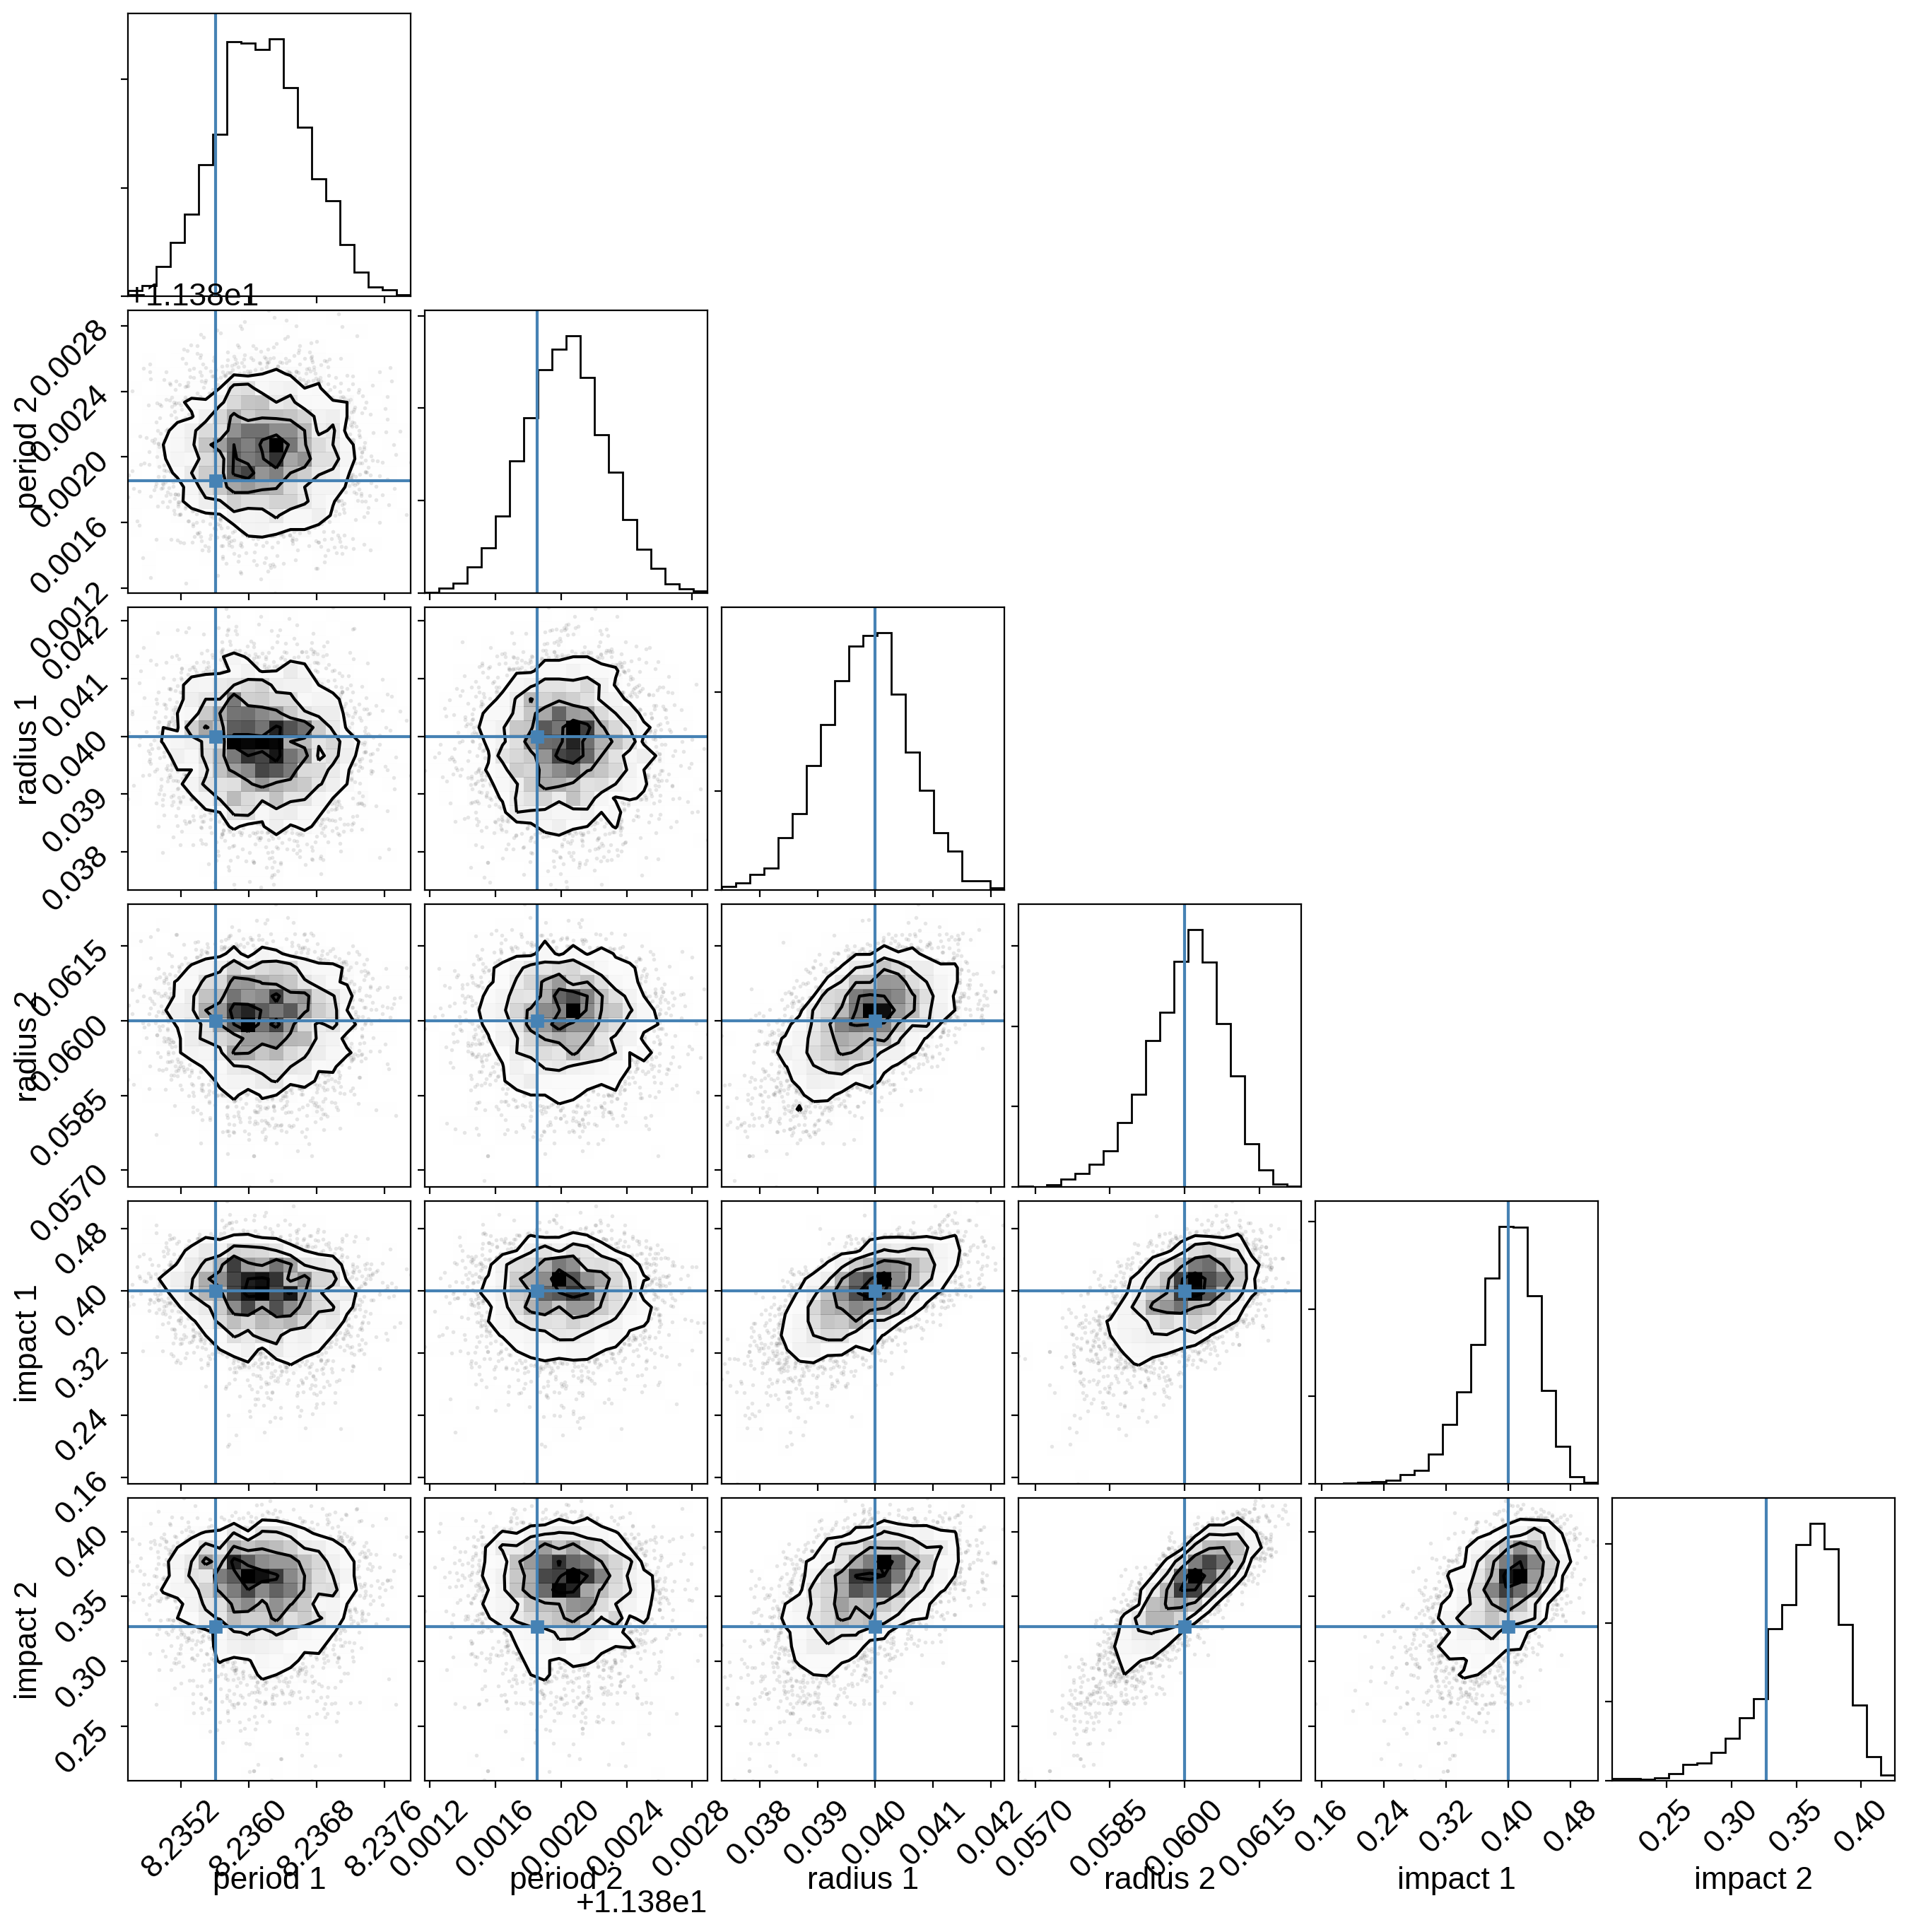

In [10]:
import corner

with model:
    truths = np.concatenate(
        list(map(np.atleast_1d, xo.eval_in_model([orbit.period, r, b])))
    )
samples = pm.trace_to_dataframe(trace, varnames=["period", "r", "b"])
corner.corner(
    samples,
    truths=truths,
    labels=["period 1", "period 2", "radius 1", "radius 2", "impact 1", "impact 2"],
);

We could also plot corner plots of the transit times, but they're not terribly enlightening in this case so let's skip it.

Finally, let's plot the posterior estimates of the the transit times in an O-C diagram:

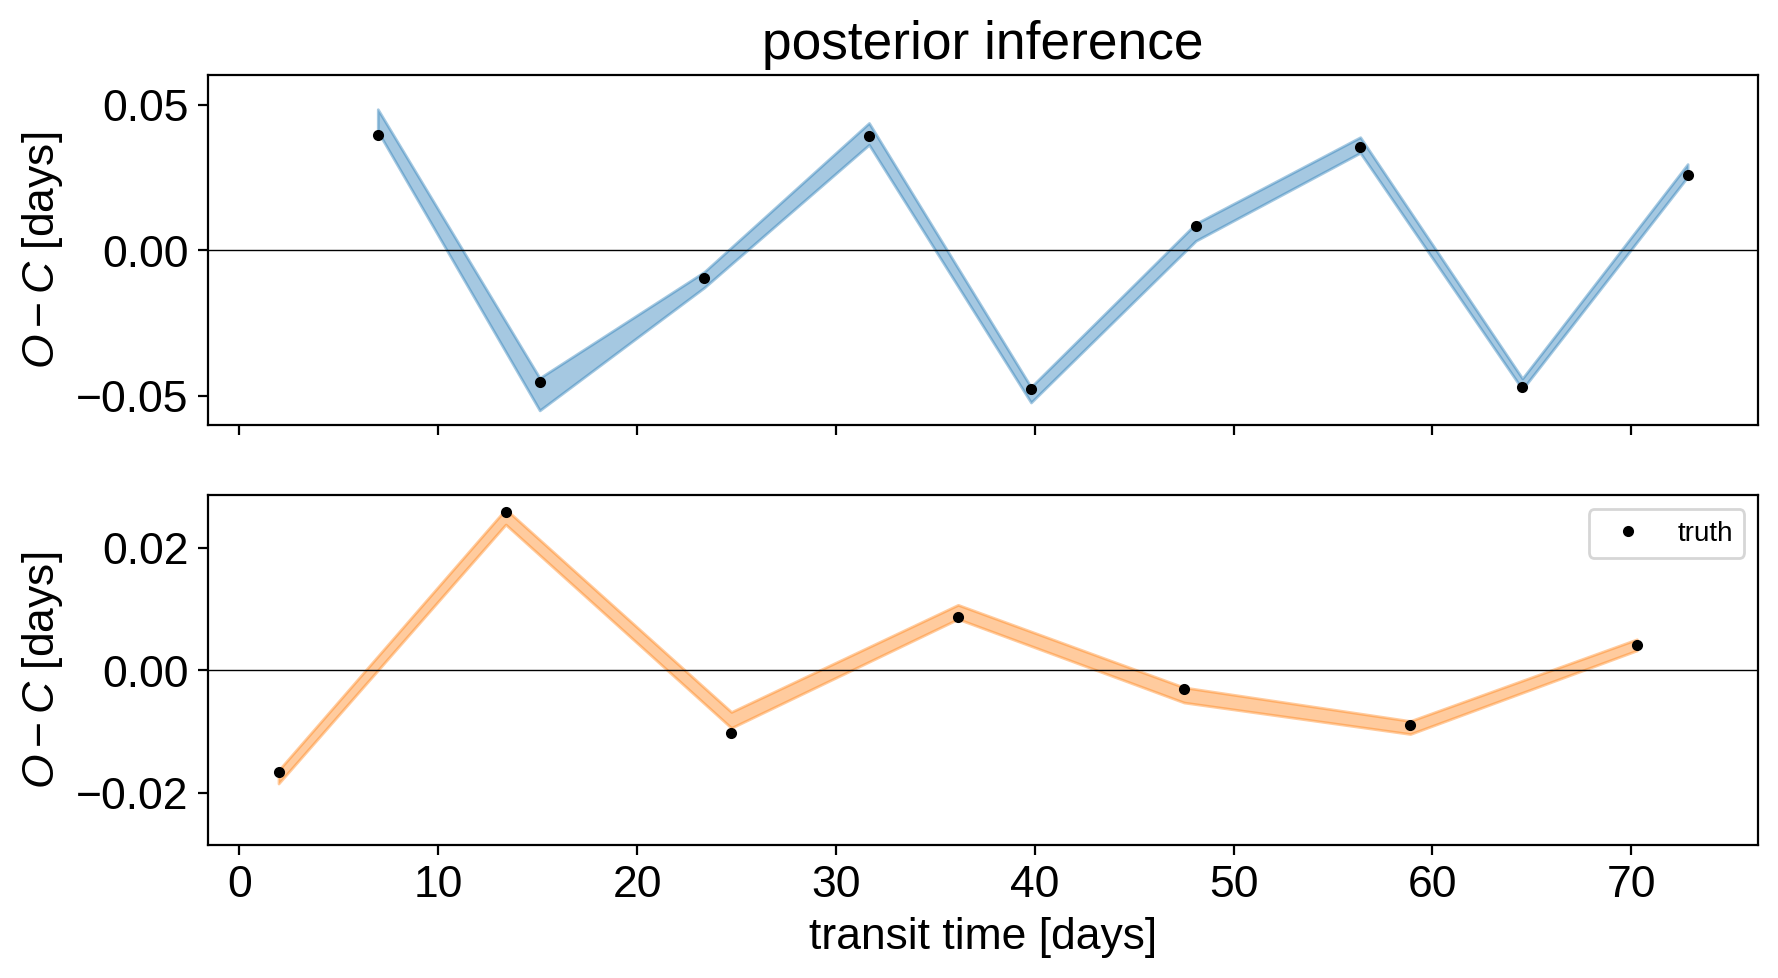

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

q = np.percentile(trace["ttvs_0"], [16, 50, 84], axis=0)
ax1.fill_between(
    np.mean(trace["tts_0"], axis=0), q[0], q[2], color="C0", alpha=0.4, edgecolor="none"
)
ref = np.polyval(
    np.polyfit(true_transit_times[0], true_ttvs[0], 1), true_transit_times[0]
)
ax1.plot(true_transit_times[0], true_ttvs[0] - ref, ".k")
ax1.axhline(0, color="k", lw=0.5)
ax1.set_ylim(np.max(np.abs(ax1.get_ylim())) * np.array([-1, 1]))

ax1.set_ylabel("$O-C$ [days]")

q = np.percentile(trace["ttvs_1"], [16, 50, 84], axis=0)
ax2.fill_between(
    np.mean(trace["tts_1"], axis=0), q[0], q[2], color="C1", alpha=0.4, edgecolor="none"
)
ref = np.polyval(
    np.polyfit(true_transit_times[1], true_ttvs[1], 1), true_transit_times[1]
)
ax2.plot(true_transit_times[1], true_ttvs[1] - ref, ".k", label="truth")
ax2.axhline(0, color="k", lw=0.5)
ax2.set_ylim(np.max(np.abs(ax2.get_ylim())) * np.array([-1, 1]))

ax2.legend(fontsize=10)
ax2.set_ylabel("$O-C$ [days]")
ax2.set_xlabel("transit time [days]")
ax1.set_title("posterior inference");

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [12]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:agol19, exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:kipping13, exoplanet:luger18, exoplanet:pymc3,
exoplanet:theano}.


In [13]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Ian Czekala and Rodrigo Luger and
            Eric Agol and Geert Barentsen and Tom Barclay},
   title = {exoplanet-dev/exoplanet v0.3.0},
   month = apr,
    year = 2020,
     doi = {10.5281/zenodo.1998447},
     url = {https://doi.org/10.5281/zenodo.1998447}
}
...
